Link to R sources: https://github.com/MatrixNorm/kaggle/tree/master/R_sources/house_prices

## DISCLAIMER. This book is probably useless apart from warming up dplyr/ggplot skills.

All sources are in R_sources/house_price/ folder.

In [2]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))

# load sources
house_prices <- source('main.R', local = TRUE)$value

# load data
combinedData <- house_prices$helpers$load_data()

# dimensions check
c(
    combinedData %>% dim %>% show_list.html("combined"),
    combinedData %>% filter(dataSource == "train") %>% dim %>% show_list.html("train"),
    combinedData %>% filter(dataSource == "test") %>% dim %>% show_list.html("test")
) %>% paste0(collapse='') %>% display_html

attr_sel <- house_prices$attributes_selection

combined 2919 82 train 1460 82 test 1459 82

In [3]:
categColnames <- house_prices$helpers$get_character_colnames(combinedData)
numerColnames <- house_prices$helpers$get_numeric_colnames(combinedData)

categColnames %>% show_list("Categorical predictors")
numerColnames %>% show_list("Numeric predictors")

(44 elems) Categorical predictors Alley BldgType BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 BsmtQual CentralAir Condition1 Condition2 Electrical ExterCond Exterior1st Exterior2nd ExterQual Fence FireplaceQu Foundation Functional GarageCond GarageFinish GarageQual GarageType Heating HeatingQC HouseStyle KitchenQual LandContour LandSlope LotConfig LotShape MasVnrType MiscFeature MSSubClass MSZoning Neighborhood PavedDrive PoolQC RoofMatl RoofStyle SaleCondition SaleType Street Utilities

(36 elems) Numeric predictors BedroomAbvGr BsmtFinSF1 BsmtFinSF2 BsmtFullBath BsmtHalfBath BsmtUnfSF EnclosedPorch Fireplaces FullBath GarageArea GarageCars GarageYrBlt GrLivArea HalfBath KitchenAbvGr LotArea LotFrontage LowQualFinSF MasVnrArea MiscVal MoSold OpenPorchSF OverallCond OverallQual PoolArea SalePrice ScreenPorch TotalBsmtSF TotRmsAbvGrd WoodDeckSF X1stFlrSF X2ndFlrSF X3SsnPorch YearBuilt YearRemodAdd YrSold

In [4]:
categData <- 
    combinedData %>% 
    select(house_prices$helpers$get_character_colnames(combinedData), SalePrice, Id)

numerData <- 
    combinedData %>% 
    select(house_prices$helpers$get_numeric_colnames(combinedData), Id)

c(
    categData %>% dim %>% show_list.html("categ"),
    numerData %>% dim %>% show_list.html("numer")
) %>% paste0(collapse='') %>% display_html

categ 2919 46 numer 2919 37

# "Normal Paper" applied to SalePrice

var value normed_value 
 
 price 755000.00000 7.226343 
 price_log 13.53447 3.781237 
 
 

 
 
 
 
 
 
 
 var L2 x y lab 
 
 price 7.46 0 5 L2 = 7.46 
 price_log 0.65 0 5 L2 = 0.65

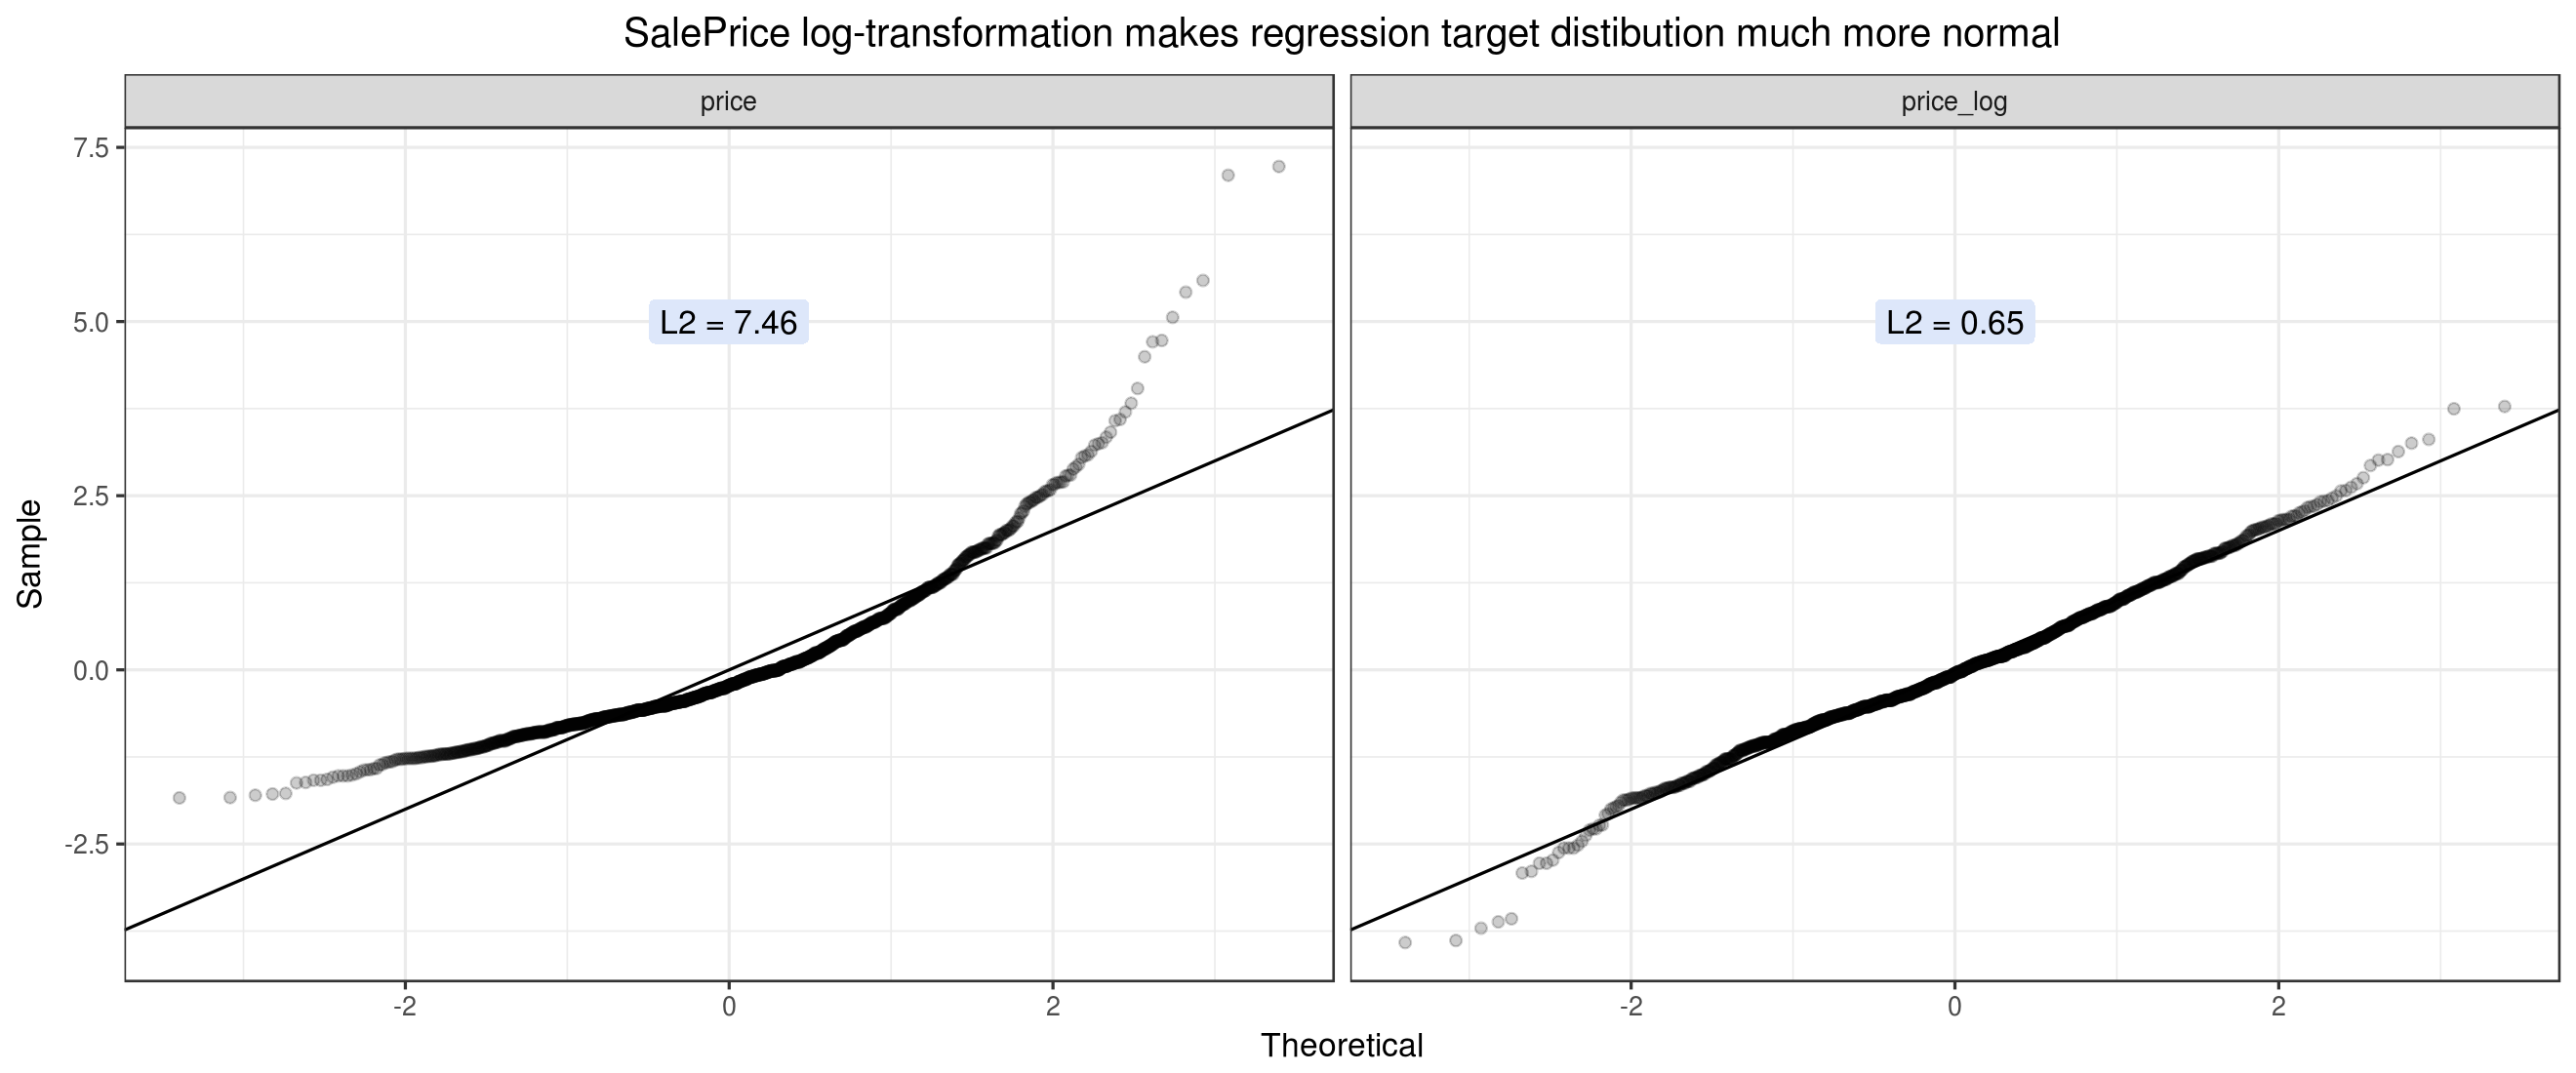

In [21]:
target_normal_paper <-
    combinedData %>% 
    select(price=SalePrice) %>% 
    na.omit %>%
    mutate(
        price_log = log(price)
    ) %>%
    gather(var, value) %>%
    group_by(var) %>%
    mutate(
        normed_value = (value - mean(value)) / sd(value)
    )

# Deviation from theoretical normal distribution in terms of L2 norm
L2_labels <-
    target_normal_paper %>%
    select(-value) %>%
    group_by(var, normed_value) %>%
    summarise(
        k = n()
    ) %>%
    arrange(var, normed_value) %>%
    group_by(var) %>%
    mutate(
        empirical = cumsum(k) / sum(k),
        theoretical = pnorm(normed_value),
        L2_delta = k*(empirical - theoretical)**2
    ) %>% 
    summarise(
        L2 = round(sum(L2_delta), 2)
    ) %>% 
    mutate(x=0, y=5, lab=paste0('L2 = ', L2))

           
show_table(
    target_normal_paper %>% arrange(var, value) %>% top_n(1, value), 
    L2_labels    
)


`@@@`(12, 5, 220)
target_normal_paper %>%
ggplot() +
geom_qq(aes(sample=normed_value), alpha=0.2) +
facet_wrap(~var, ncol=2) +
geom_abline(slope=1) +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
ylab("Sample") + xlab("Theoretical") +
labs(
    title = "SalePrice log-transformation makes regression target distibution much more normal"
) +
geom_text(aes(x, y, label=lab), data=L2_labels) + 
geom_label(aes(x, y, label=lab), data=L2_labels, fill='#dde7fa', label.size=0)

In [6]:
# alternative L2 calculation
target_normal_paper %>%
select(-value) %>%
group_by(var) %>%
nest %>%
mutate(
    L2 = map_dbl(data, function(data) {
        nval <- sort(data[['normed_value']])
        cdf <- ecdf(nval)
        empir <- cdf(nval)
        theor <- pnorm(nval)
        round(sum((empir - theor)**2), 2)
    })
) %>%
select(-data)

var       L2  
1 price     7.46
2 price_log 0.65

# Entropy of attribute distributions

Zero entropy means constant distibution of a factor and thus it's zero predictive power. So maybe entropy means something... or not.

Large entropy 
 
 
 var entropy type basket 
 
 TotalBsmtSF 9.348757 Numeric 4 
 BsmtUnfSF 9.390885 Numeric 4 
 X1stFlrSF 9.601608 Numeric 4 
 GrLivArea 9.882939 Numeric 4 
 LotArea 10.400602 Numeric 4 
 
 

 
 
 
 
 Small entropy 
 
 
 var entropy type basket 
 
 Utilities 0.01262749 Categorical 1 
 PoolQC 0.03820308 Categorical 1 
 Street 0.03850369 Categorical 1 
 PoolArea 0.05767714 Numeric 1 
 Condition2 0.10643374 Categorical 1

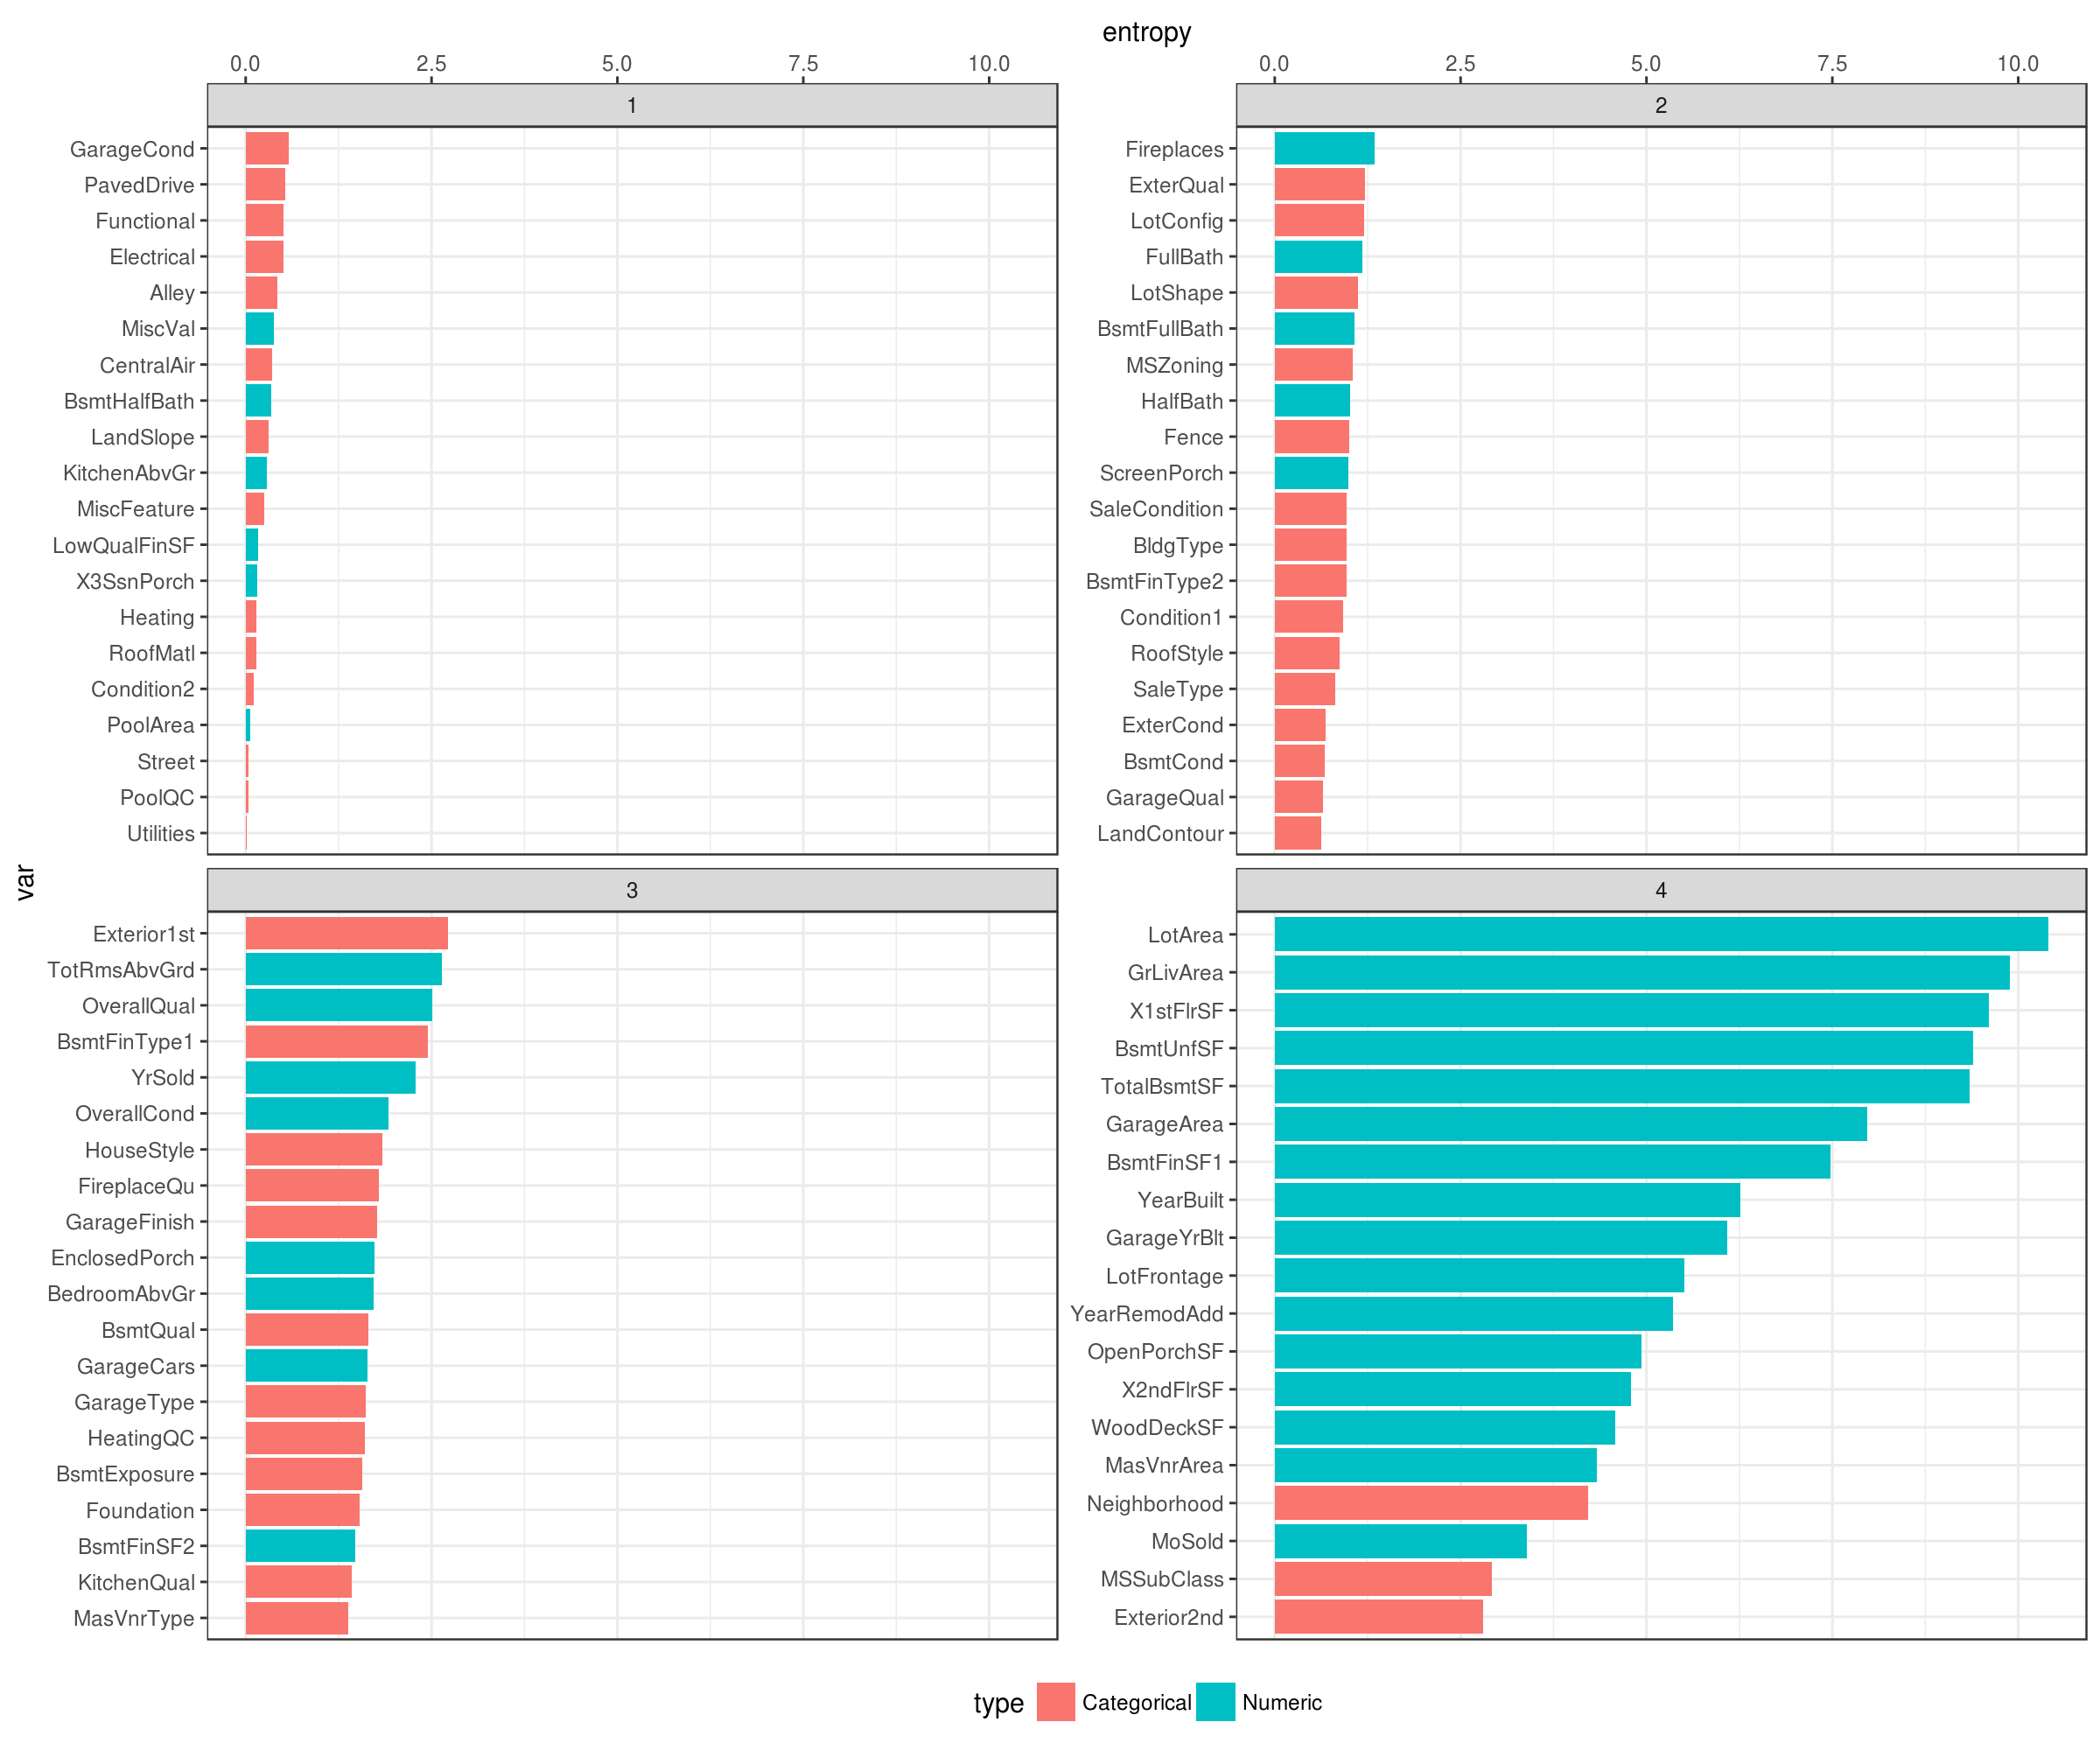

In [24]:
predictorsByEntropy <- 
    bind_rows(
        attr_sel$entropy$arrange_vars(
            numerData %>% select(-SalePrice, -Id)
        ) %>% mutate(type = "Numeric"),

        attr_sel$entropy$arrange_vars(
            categData %>% select(-SalePrice, -Id)
        ) %>% mutate(type = "Categorical")
    ) %>% 
    arrange(entropy) %>%
    mutate(
        var = factor(var, levels=var),
        basket = floor(4*(row_number() - 1)/nrow(.)) + 1
    )


show_table(
    list(predictorsByEntropy %>% tail(5), "Large entropy"),
    list(predictorsByEntropy %>% head(5), "Small entropy")
)


`@@@`(12, 10, 200)
predictorsByEntropy %>%
ggplot(aes(x=var, y=entropy, fill=type)) +
geom_bar(stat="identity") +
facet_wrap(~basket, nrow = 2, ncol = 2, scales="free_y") +
coord_flip() +
scale_y_continuous(position = "top") +
theme_bw() +
theme(legend.position = "bottom")

# Separation between groups
##### Aplies only to categorical predictors. Variation on ANOVA theme.
This is custom measure of how levels of categorical variables are separated between each other relative to sale price. The bigger is the separation the more should be variable meaningful for the price prediction. If there is no separation between levels of a given variable then this variable is useless.

Large separation 
 
 
 var score type basket 
 
 BsmtFinType1 0.1377131 Categorical 2 
 GarageFinish 0.3181379 Categorical 2 
 BsmtQual 0.4913273 Categorical 2 
 KitchenQual 0.5455861 Categorical 2 
 ExterQual 0.6638143 Categorical 2 
 
 

 
 
 
 
 Small separation 
 
 
 var score type basket 
 
 Utilities 0.0001594599 Categorical 1 
 LandSlope 0.0006420930 Categorical 1 
 RoofMatl 0.0009775133 Categorical 1 
 Condition2 0.0010841188 Categorical 1 
 LotConfig 0.0011534694 Categorical 1

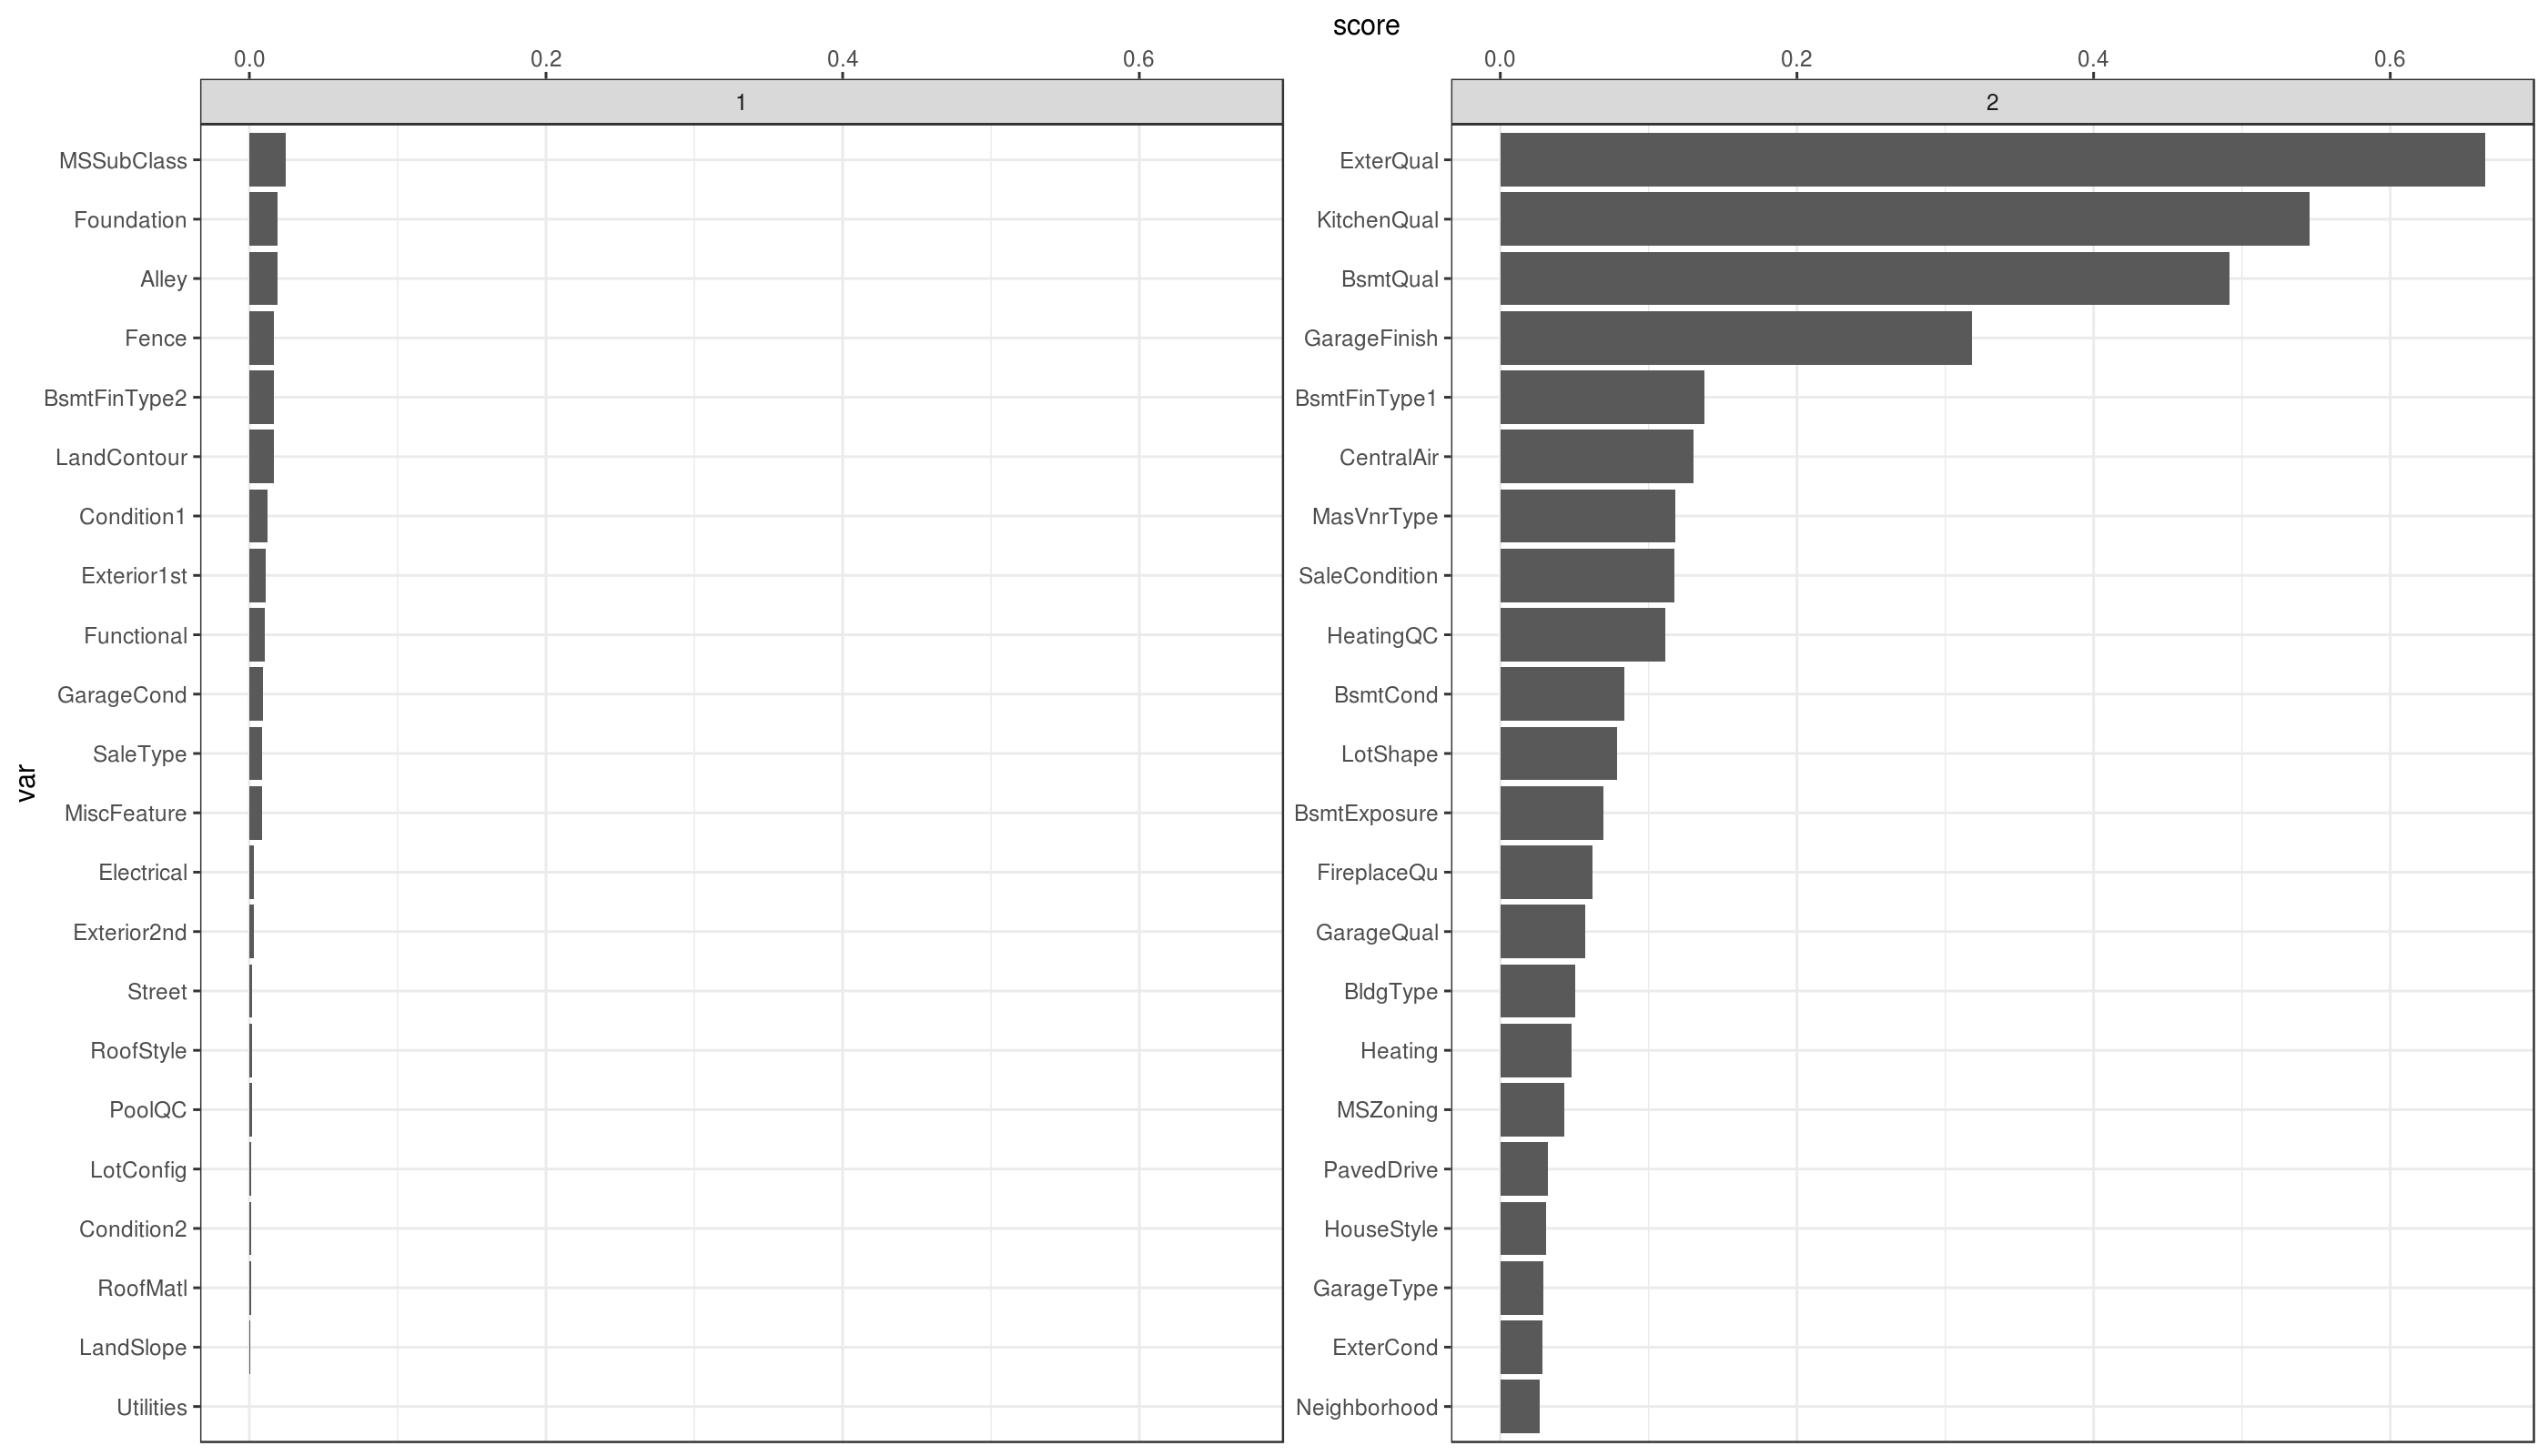

In [28]:
predictorsBySeparation <- 
    attr_sel$groups_separation$arrange_vars(
        df = categData %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice, -Id),
        target_var = price_log
    ) %>% 
    mutate(type = "Categorical") %>%
    mutate(
        var = factor(var, levels=var),
        basket = floor(2*(row_number() - 1)/nrow(.)) + 1
    )


show_table(
    list(predictorsBySeparation %>% tail(5), "Large separation"),
    list(predictorsBySeparation %>% head(5), "Small separation")
)


`@@@`(14, 8, 200)
predictorsBySeparation %>%
ggplot(aes(x=var, y=score)) +
geom_bar(stat="identity") +
facet_wrap(~basket, nrow = 1, ncol = 2, scales="free_y") +
coord_flip() +
scale_y_continuous(position = "top") +
theme_bw() +
theme(legend.position = "bottom")

### Visualising separation with two opposite test cases

In [34]:
# Helper function that orderes factor levels by SalePrice's mean value at that level.
# Otherwise ggplot will by default order levels lexicographically.
attr_sel$order_factor_by_target(
    df = categData %>% filter(!is.na(SalePrice)) %>% select(ExterQual, SalePrice), 
    factor_var = ExterQual, 
    target_var = SalePrice
)$ExterQual %>% levels %>% show_list

Fa TA Gd Ex

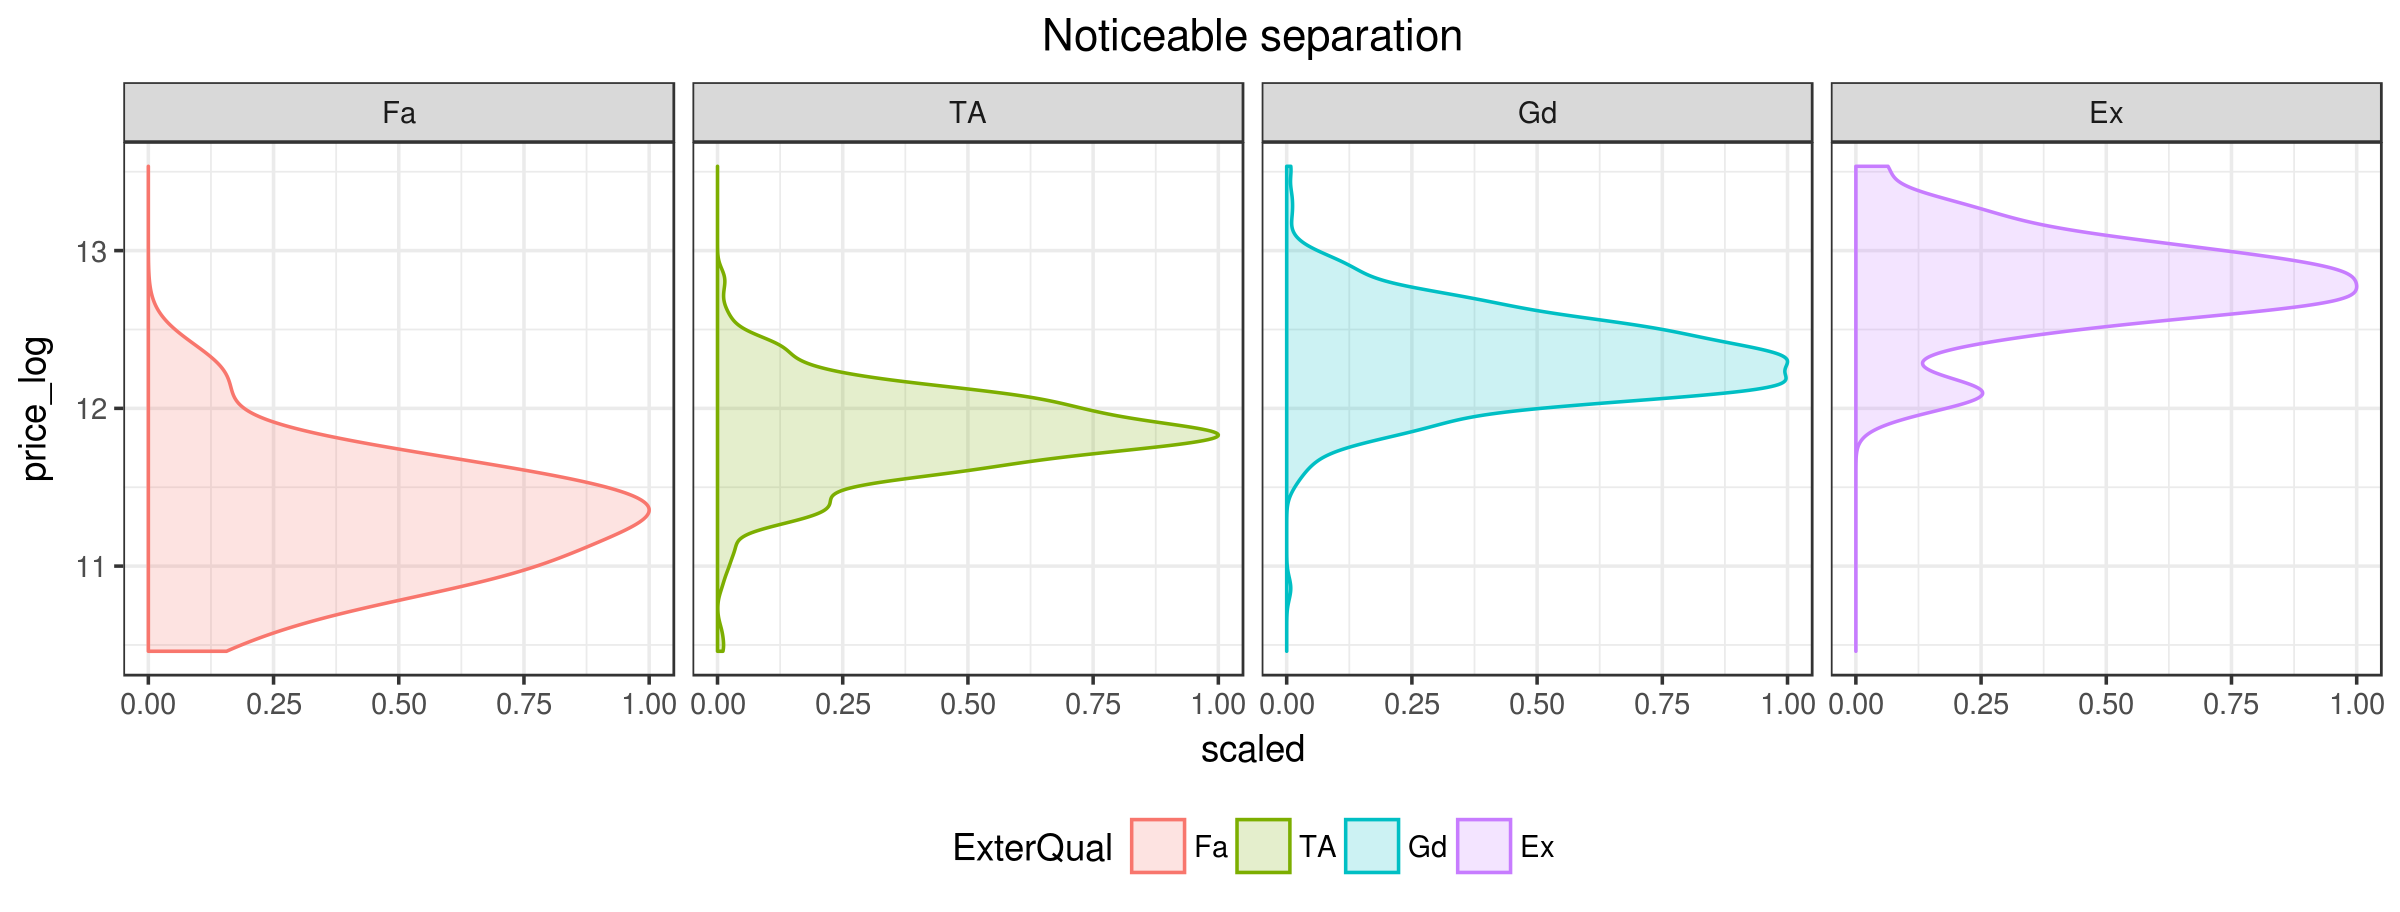

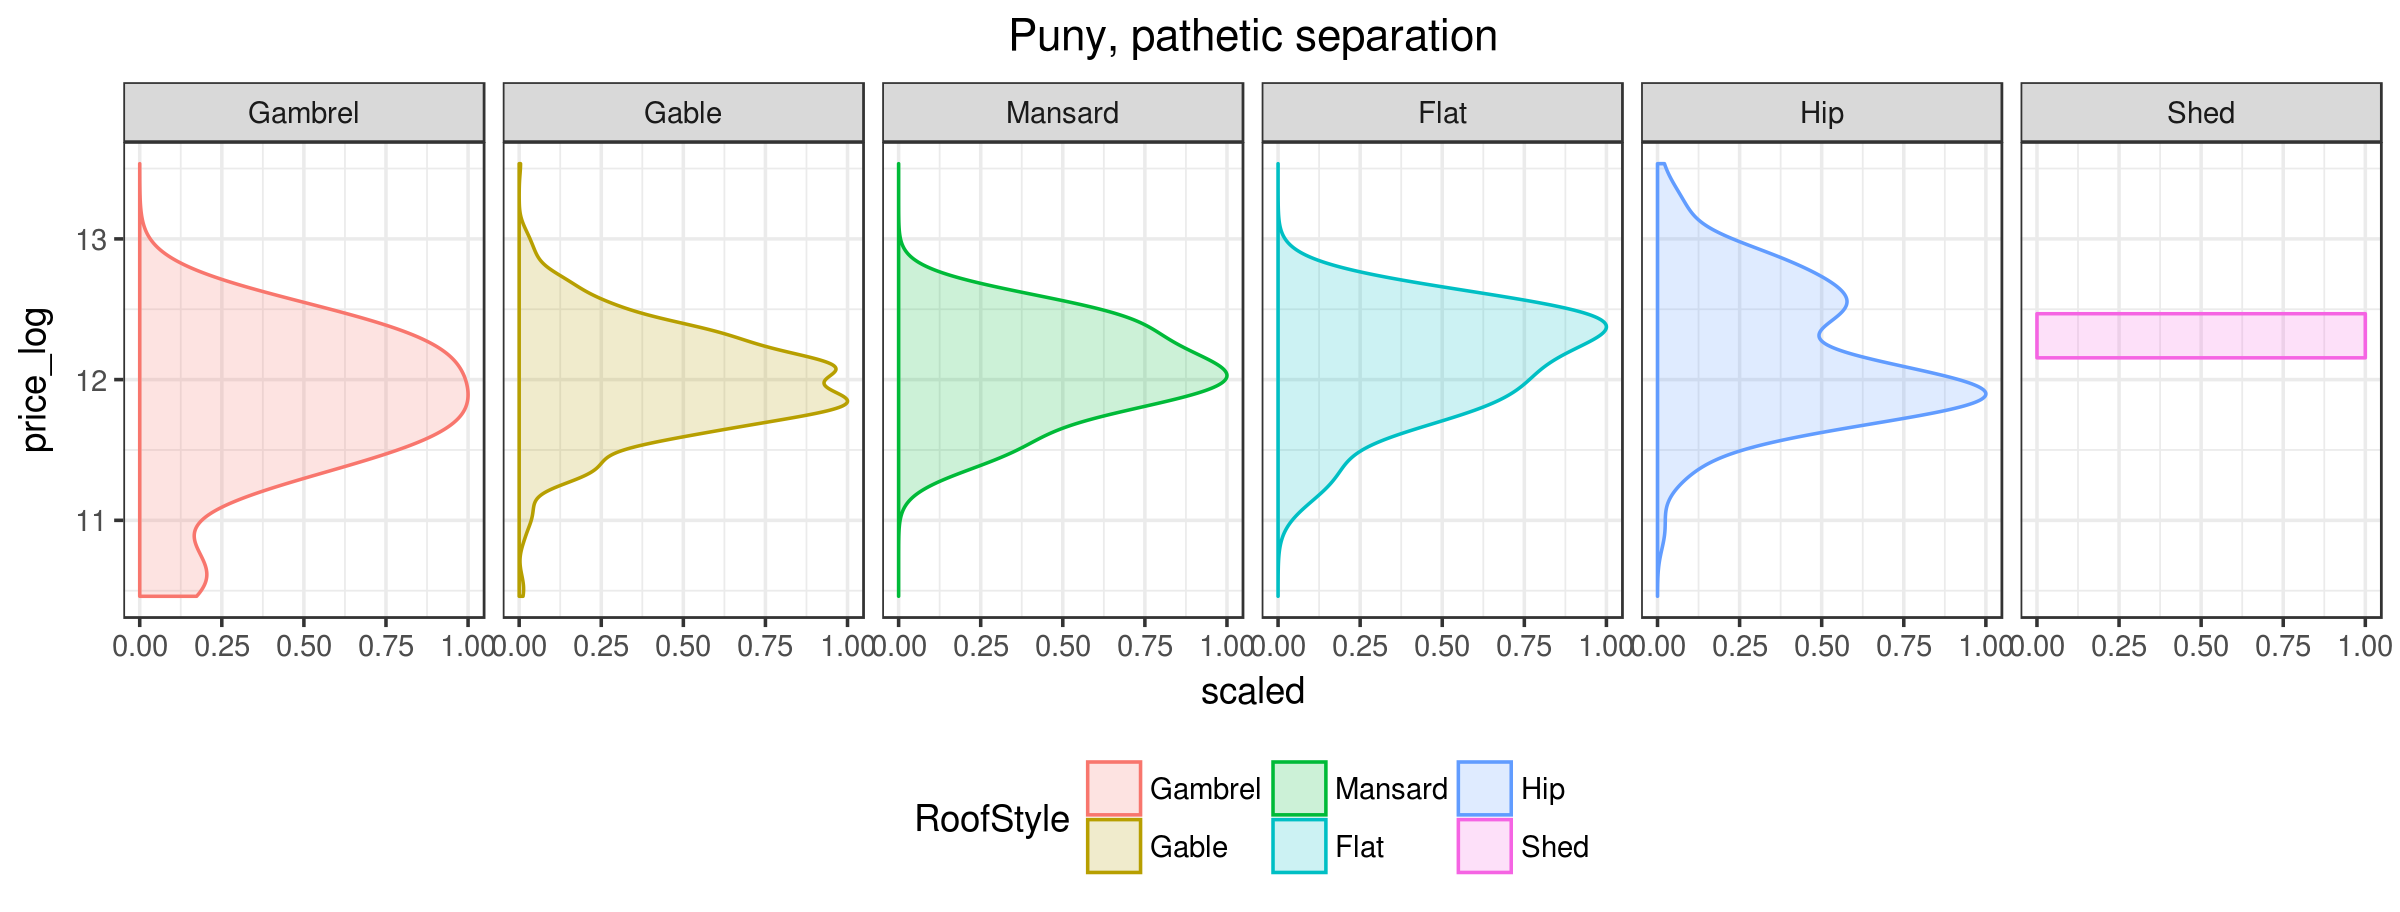

In [36]:
df <- 
    categData %>% 
    filter(!is.na(SalePrice)) %>% 
    select(ExterQual, RoofStyle, SalePrice) %>%
    mutate(price_log = log(SalePrice)) %>%
    select(-SalePrice)


`@@@`(10, 3.8, 240)
attr_sel$order_factor_by_target(
    df = df, 
    factor_var = ExterQual, 
    target_var = price_log
) %>%
ggplot(aes(price_log, color=ExterQual)) +
geom_density(aes(y=..scaled.., fill=ExterQual), alpha=.2) +
facet_wrap(~ExterQual, nrow=1) +
coord_flip() +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
labs(title = "Noticeable separation")


`@@@`(10, 3.8, 240)
attr_sel$order_factor_by_target(
    df = df, 
    factor_var = RoofStyle, 
    target_var = price_log
) %>%
ggplot(aes(price_log, color=RoofStyle)) +
geom_density(aes(y=..scaled.., fill=RoofStyle), alpha=.2) +
facet_wrap(~RoofStyle, nrow=1) +
coord_flip() +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
labs(title = "Puny, pathetic separation")

### Ordering factors by $R^2$ of $log(SalePrice) \sim factor$

Large R2 
 
 
 var r2 type 
 
 ExterQual 0.4611220 Categorical 
 GarageCars 0.4632501 Numeric 
 GrLivArea 0.4912982 Numeric 
 Neighborhood 0.5708078 Categorical 
 OverallQual 0.6677904 Numeric 
 
 

 
 
 
 
 Small R2 
 
 
 var r2 type 
 
 BsmtFinSF2 2.335219e-05 Numeric 
 BsmtHalfBath 2.651317e-05 Numeric 
 Utilities 1.595693e-04 Categorical 
 MiscVal 4.008332e-04 Numeric 
 OverallCond 1.359249e-03 Numeric

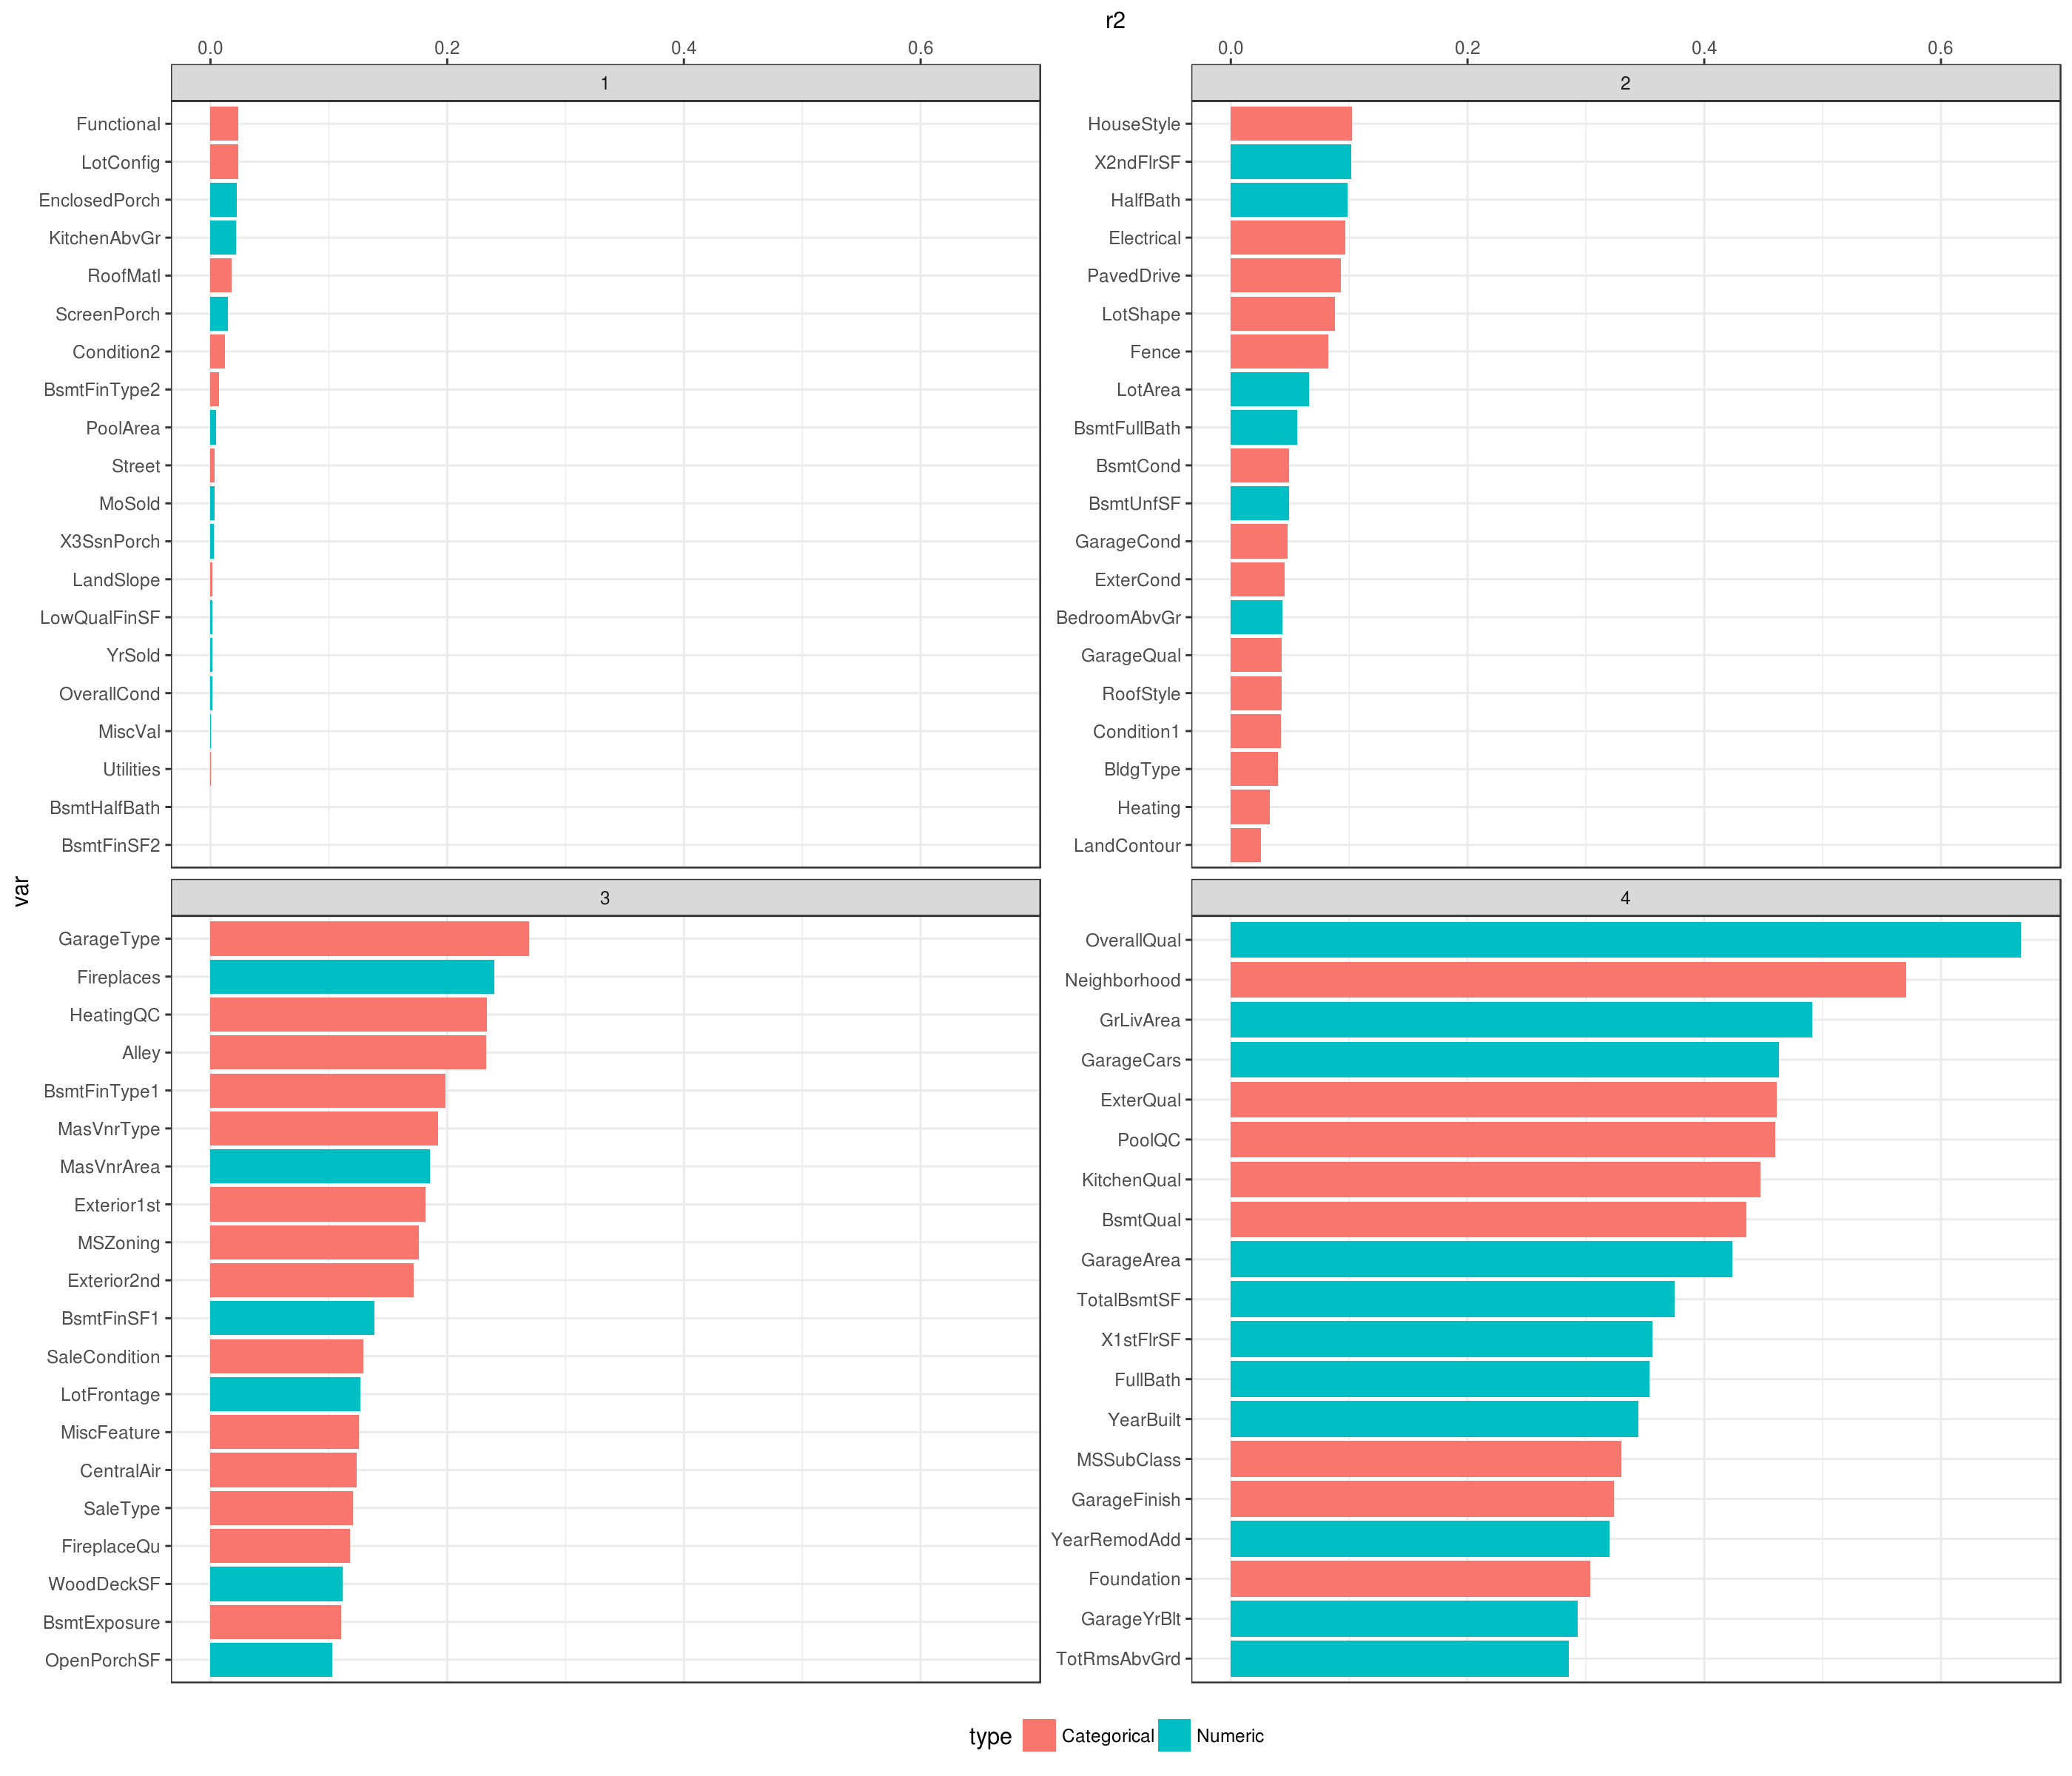

In [38]:
categ_vars_by_r2 <- 
    attr_sel$Rsquared$arrange_vars(
        df = categData %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice, -Id), 
        target_var = price_log
    )

numeric_vars_by_r2 <- 
    attr_sel$Rsquared$arrange_vars(
        df = numerData %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice, -Id), 
        target_var = price_log
    )

predictorsByR2 <- bind_rows(
    categ_vars_by_r2 %>% mutate(type = "Categorical"),
    numeric_vars_by_r2 %>% mutate(type = "Numeric")
) %>% arrange(r2)


show_table(
    list(predictorsByR2 %>% tail(5), "Large R2"),
    list(predictorsByR2 %>% head(5), "Small R2")
)


`@@@`(14, 12, 200)
predictorsByR2 %>%
mutate(
    var = factor(var, levels=var),
    basket = floor(4*(row_number() - 1)/nrow(.)) + 1
) %>%
ggplot(aes(x=var, y=r2, fill=type)) +
geom_bar(stat="identity") +
facet_wrap(~basket, nrow = 2, ncol = 2, scales="free_y") +
coord_flip() +
scale_y_continuous(position = "top") +
theme_bw() +
theme(legend.position = "bottom")

# By Fisher statistics

#### Basically one-way ANOVA

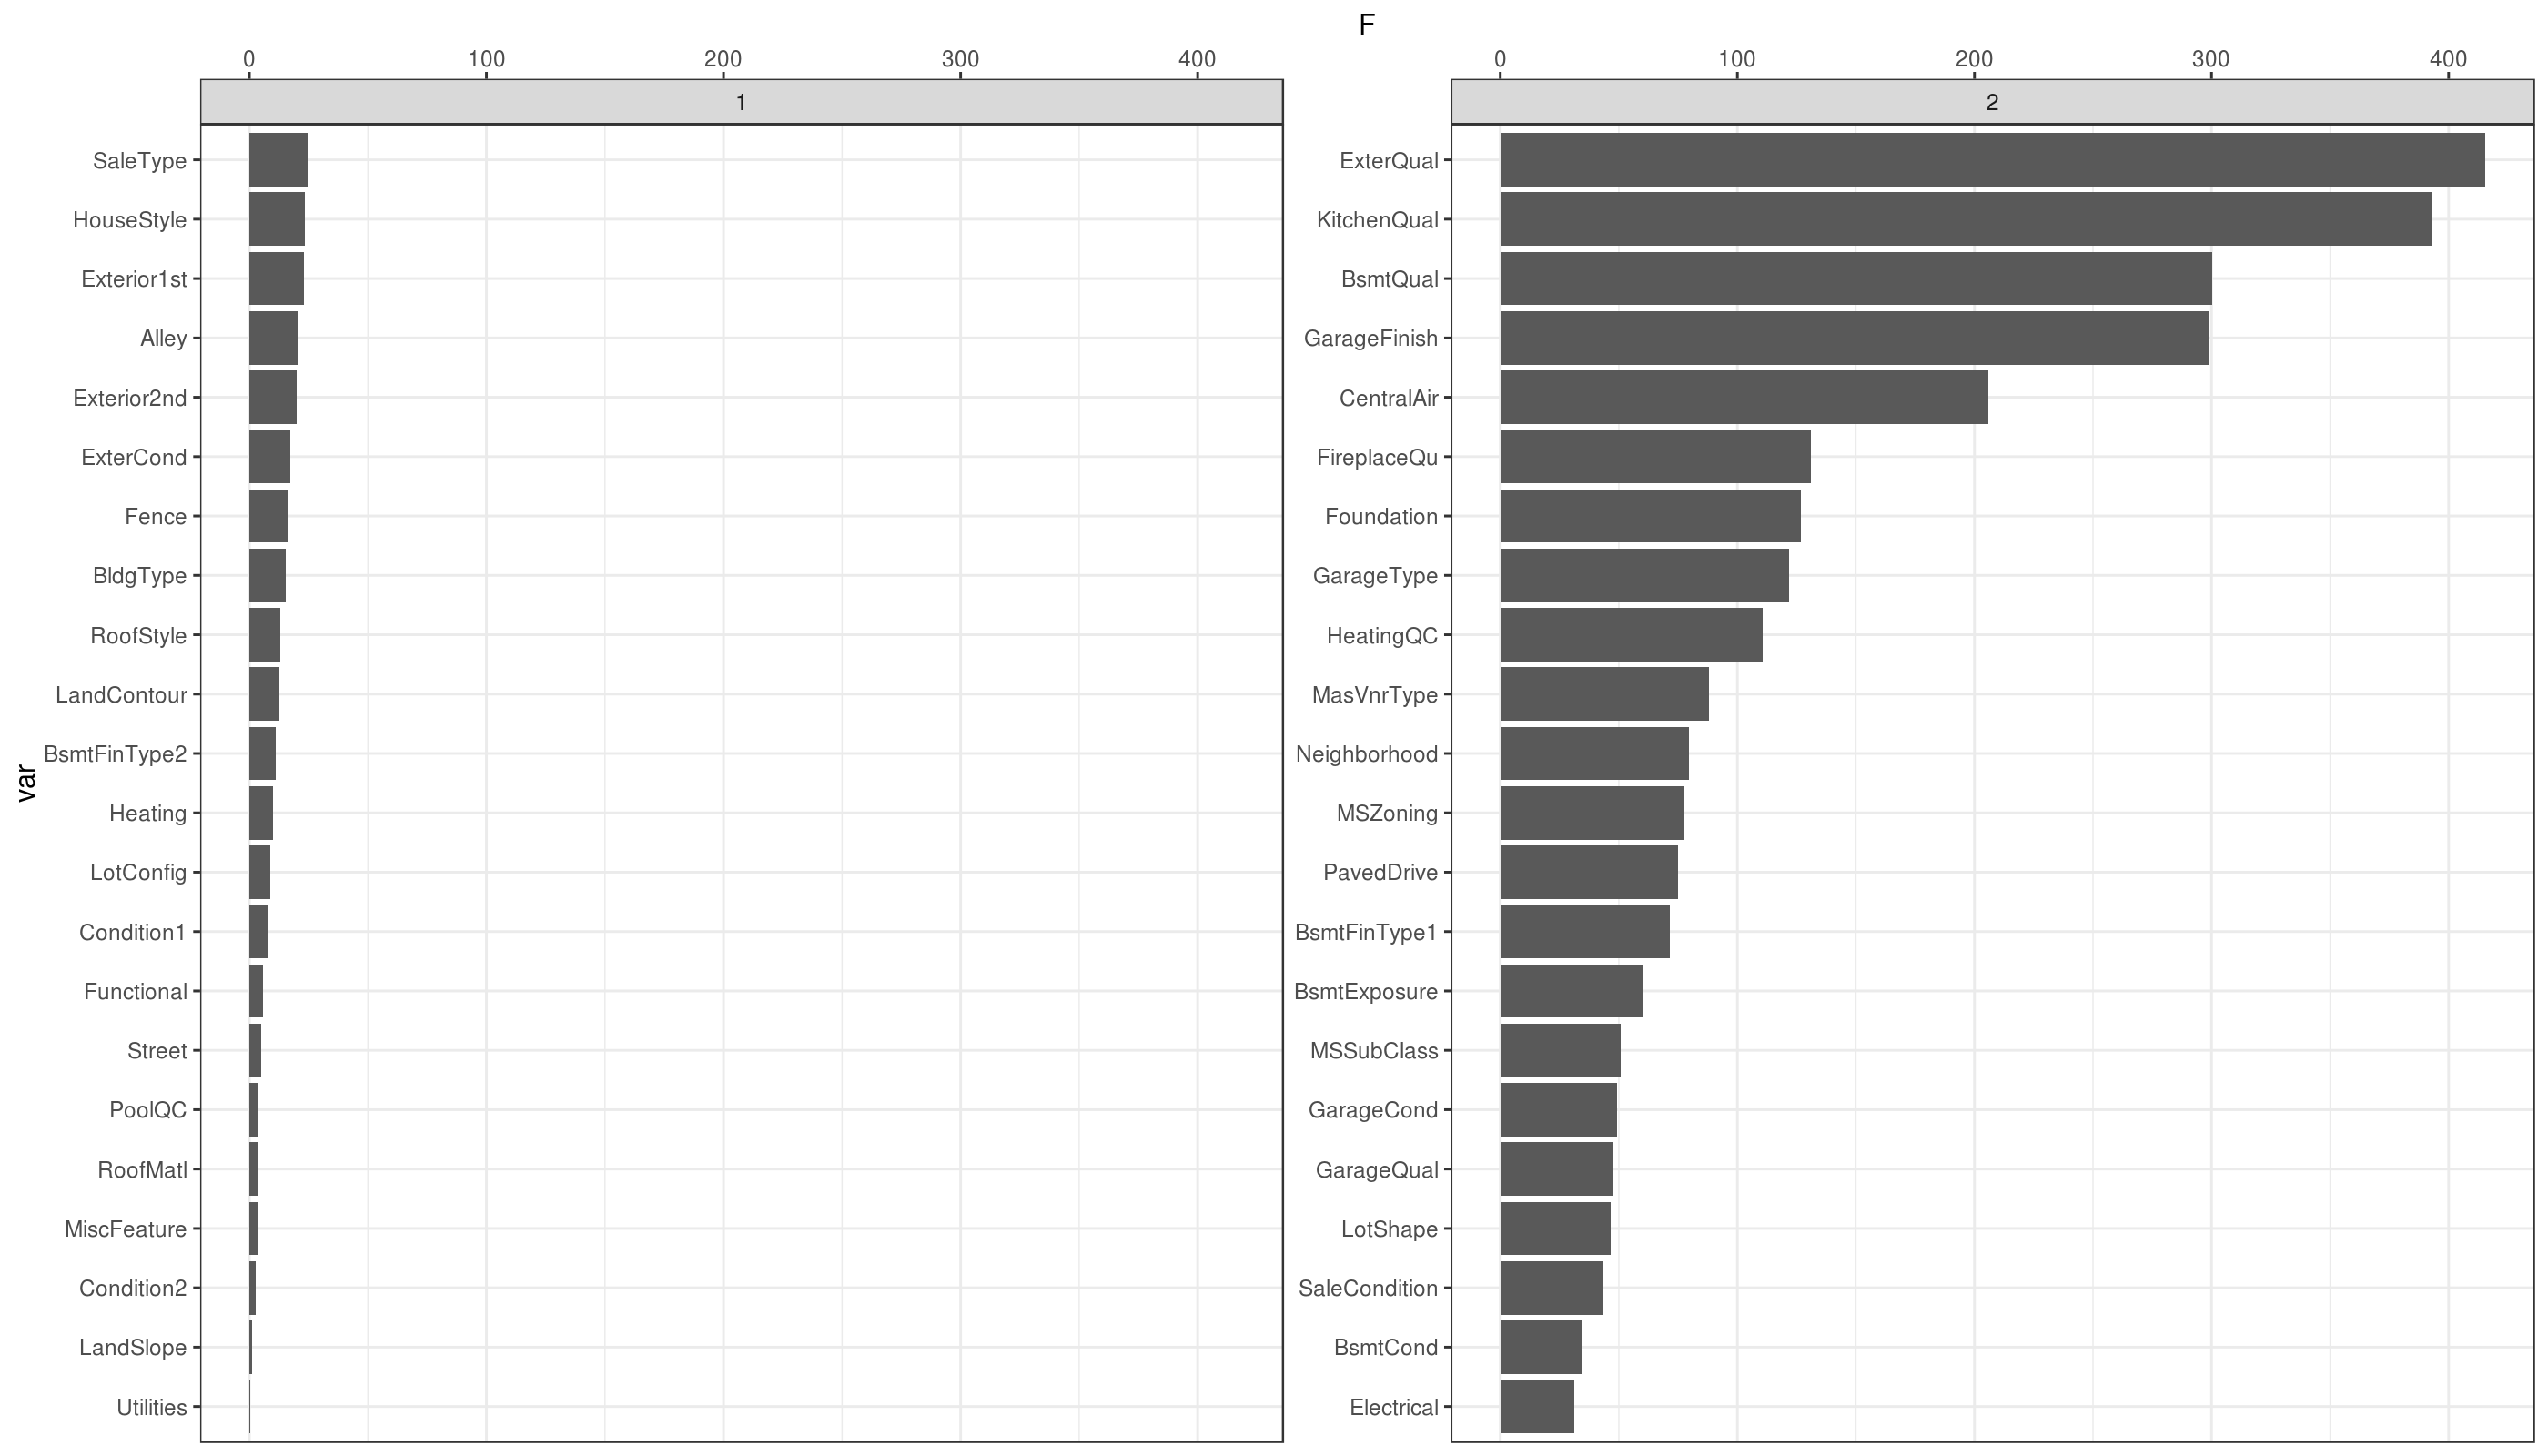

In [12]:
predictorsByFisher <- attr_sel$anova$arrange_vars(
    df = categData %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice, -Id), 
    target_var = price_log
) %>% mutate(type = "Categorical")

`@@@`(14, 8, 200)
predictorsByFisher %>%
mutate(
    var = factor(var, levels=var),
    basket = floor(2*(row_number() - 1)/nrow(.)) + 1
) %>%
ggplot(aes(x=var, y=F)) +
geom_bar(stat="identity") +
facet_wrap(~basket, nrow = 1, ncol = 2, scales="free_y") +
coord_flip() +
scale_y_continuous(position = "top") +
theme_bw() +
theme(legend.position = "bottom")

# Everything together

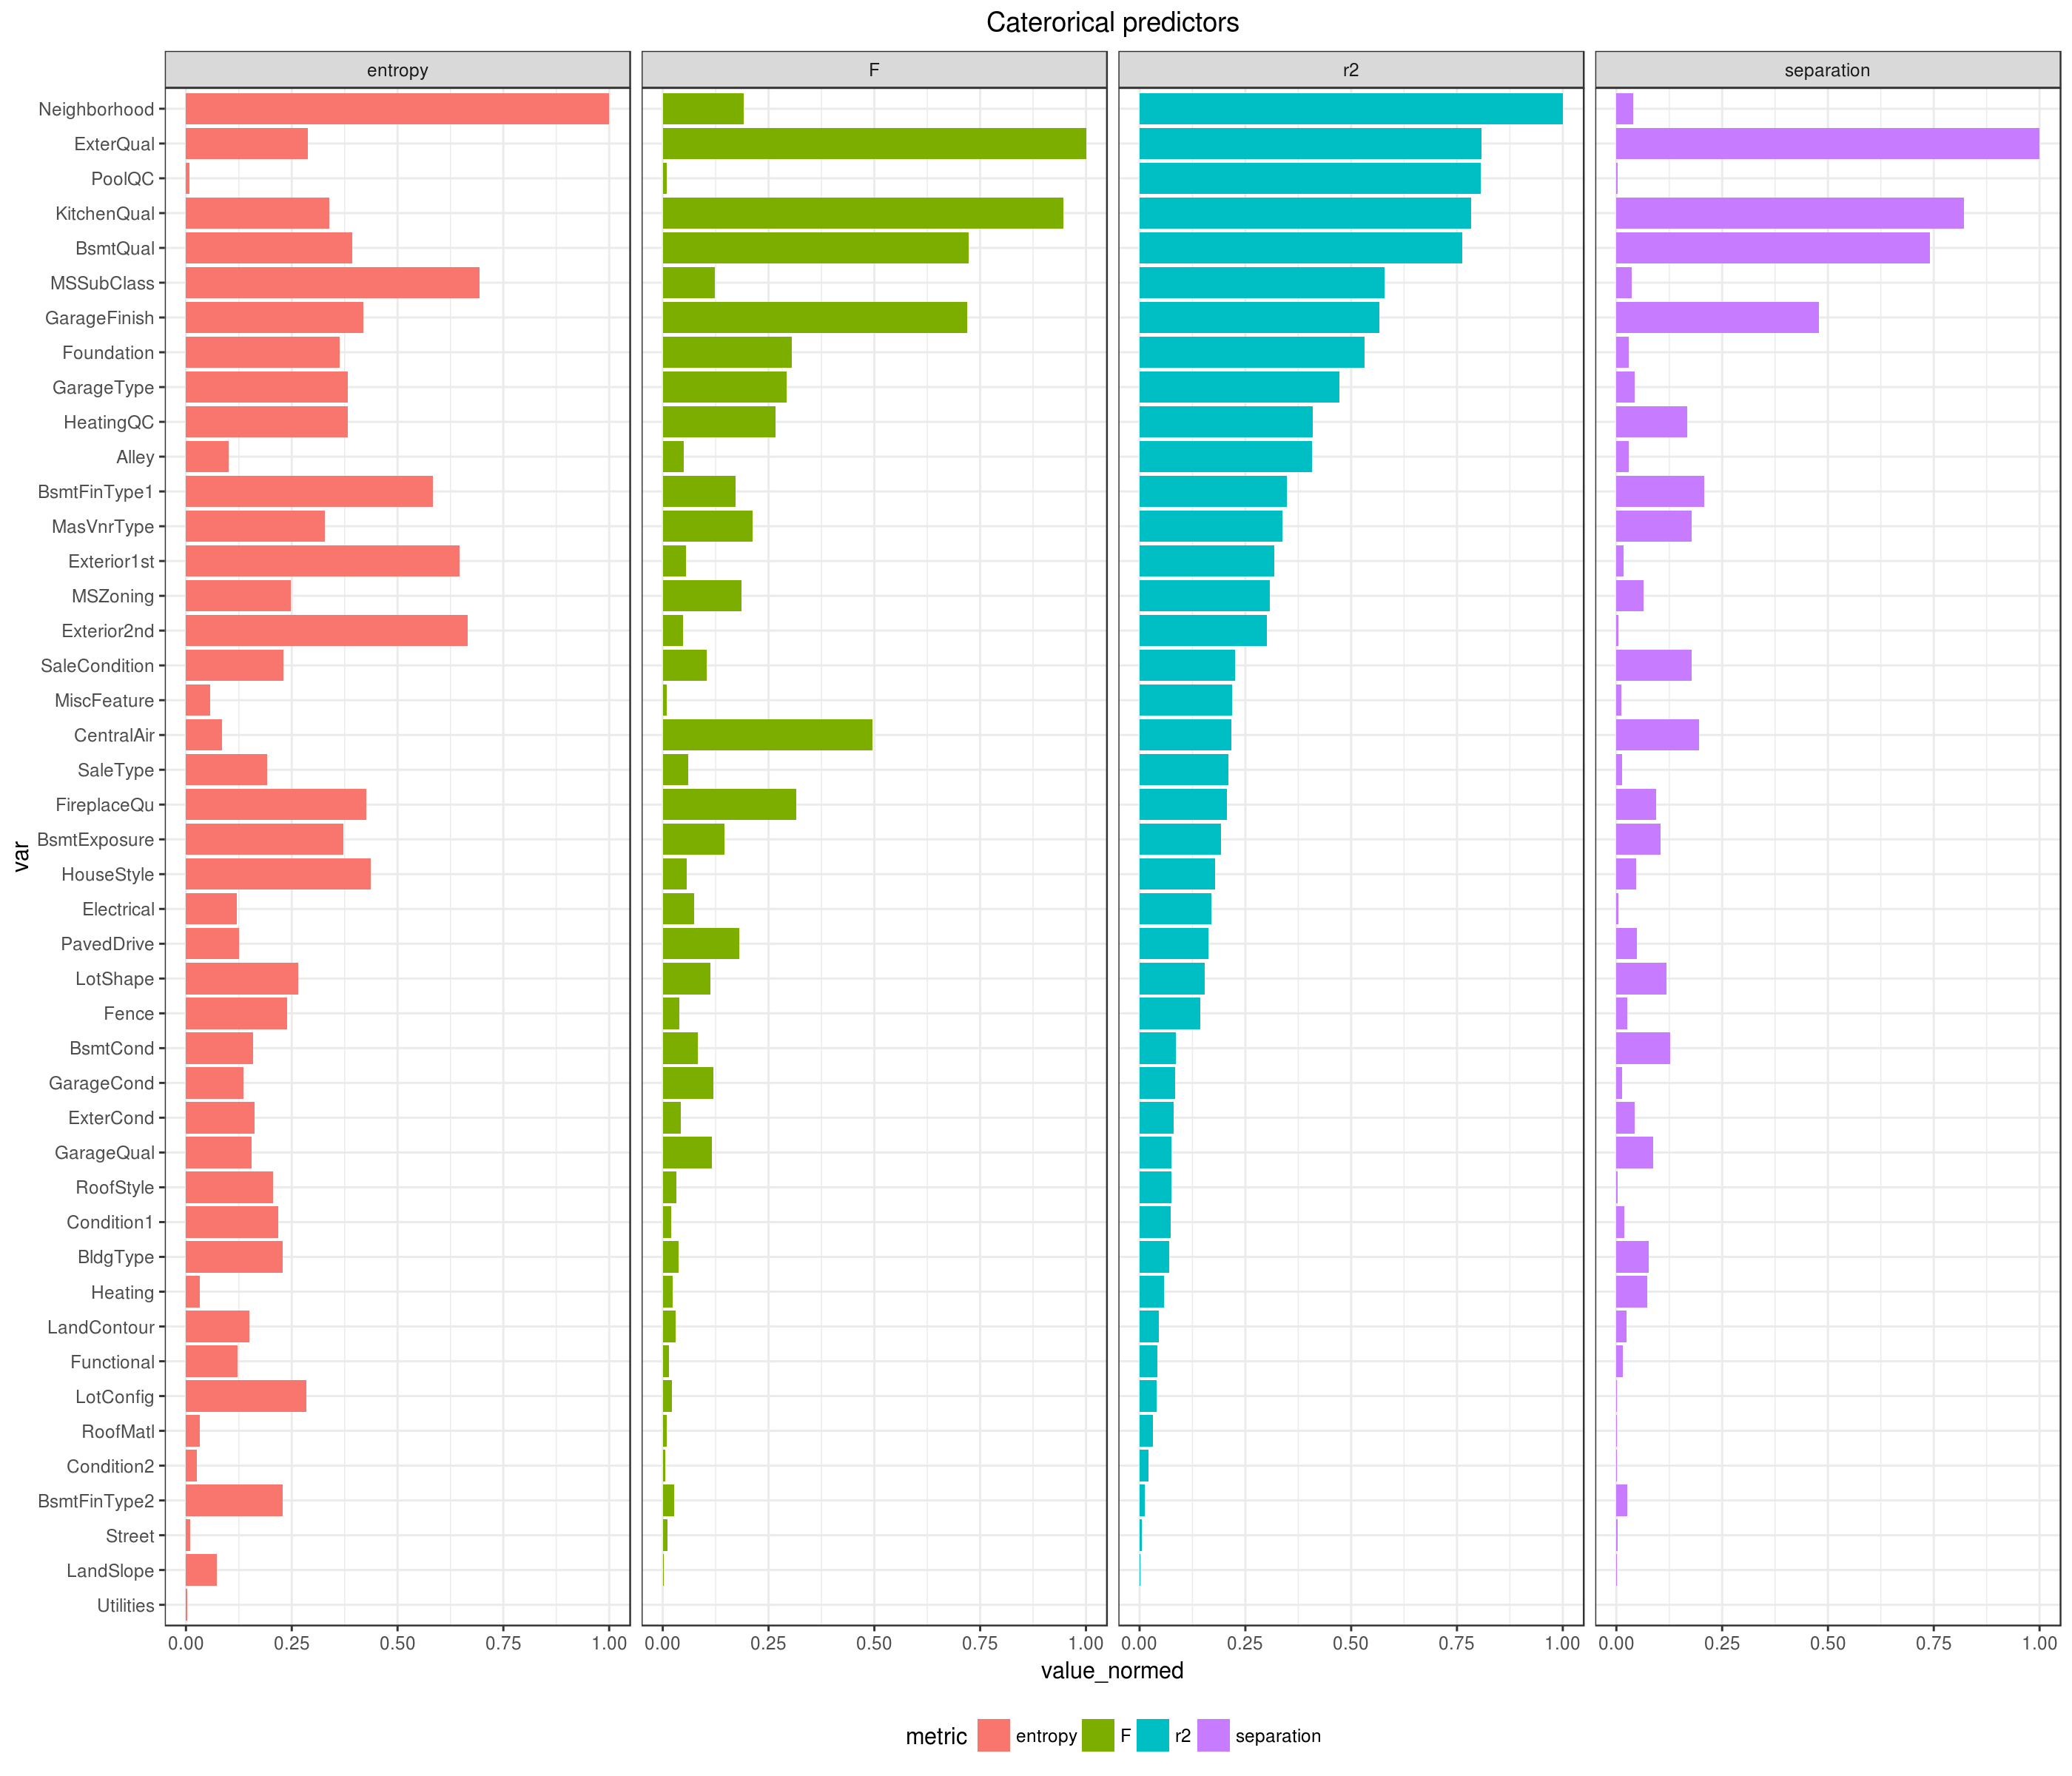

In [13]:
df <-
    bind_rows(
        predictorsByEntropy %>% gather(metric, value, -var, -type),
        predictorsBySeparation %>% rename(separation=score) %>% gather(metric, value, -var, -type),
        predictorsByR2 %>% gather(metric, value, -var, -type),
        predictorsByFisher %>% gather(metric, value, -var, -type)
    ) %>% 
    group_by(type, metric) %>%
    mutate(value_normed = value / max(value)) %>%
    ungroup %>%
    arrange(type, metric, value_normed)


df_cat <-
    df %>% 
    filter(type == "Categorical") %>%
    select(-type, -value) %>%
    spread(metric, value_normed)

df_cat <-
    df_cat %>%
    mutate(
        var = factor(var, levels = df_cat %>% select(var, r2) %>% arrange(r2) %>% `[[`(1))
    ) %>%
    gather(metric, value_normed, -var)


`@@@`(14, 12, 200)
df_cat %>%
ggplot(aes(x=var, y=value_normed, fill=metric)) +
geom_bar(stat="identity") +
coord_flip() +
facet_wrap(~metric, nrow = 1) +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
labs(title = "Caterorical predictors")

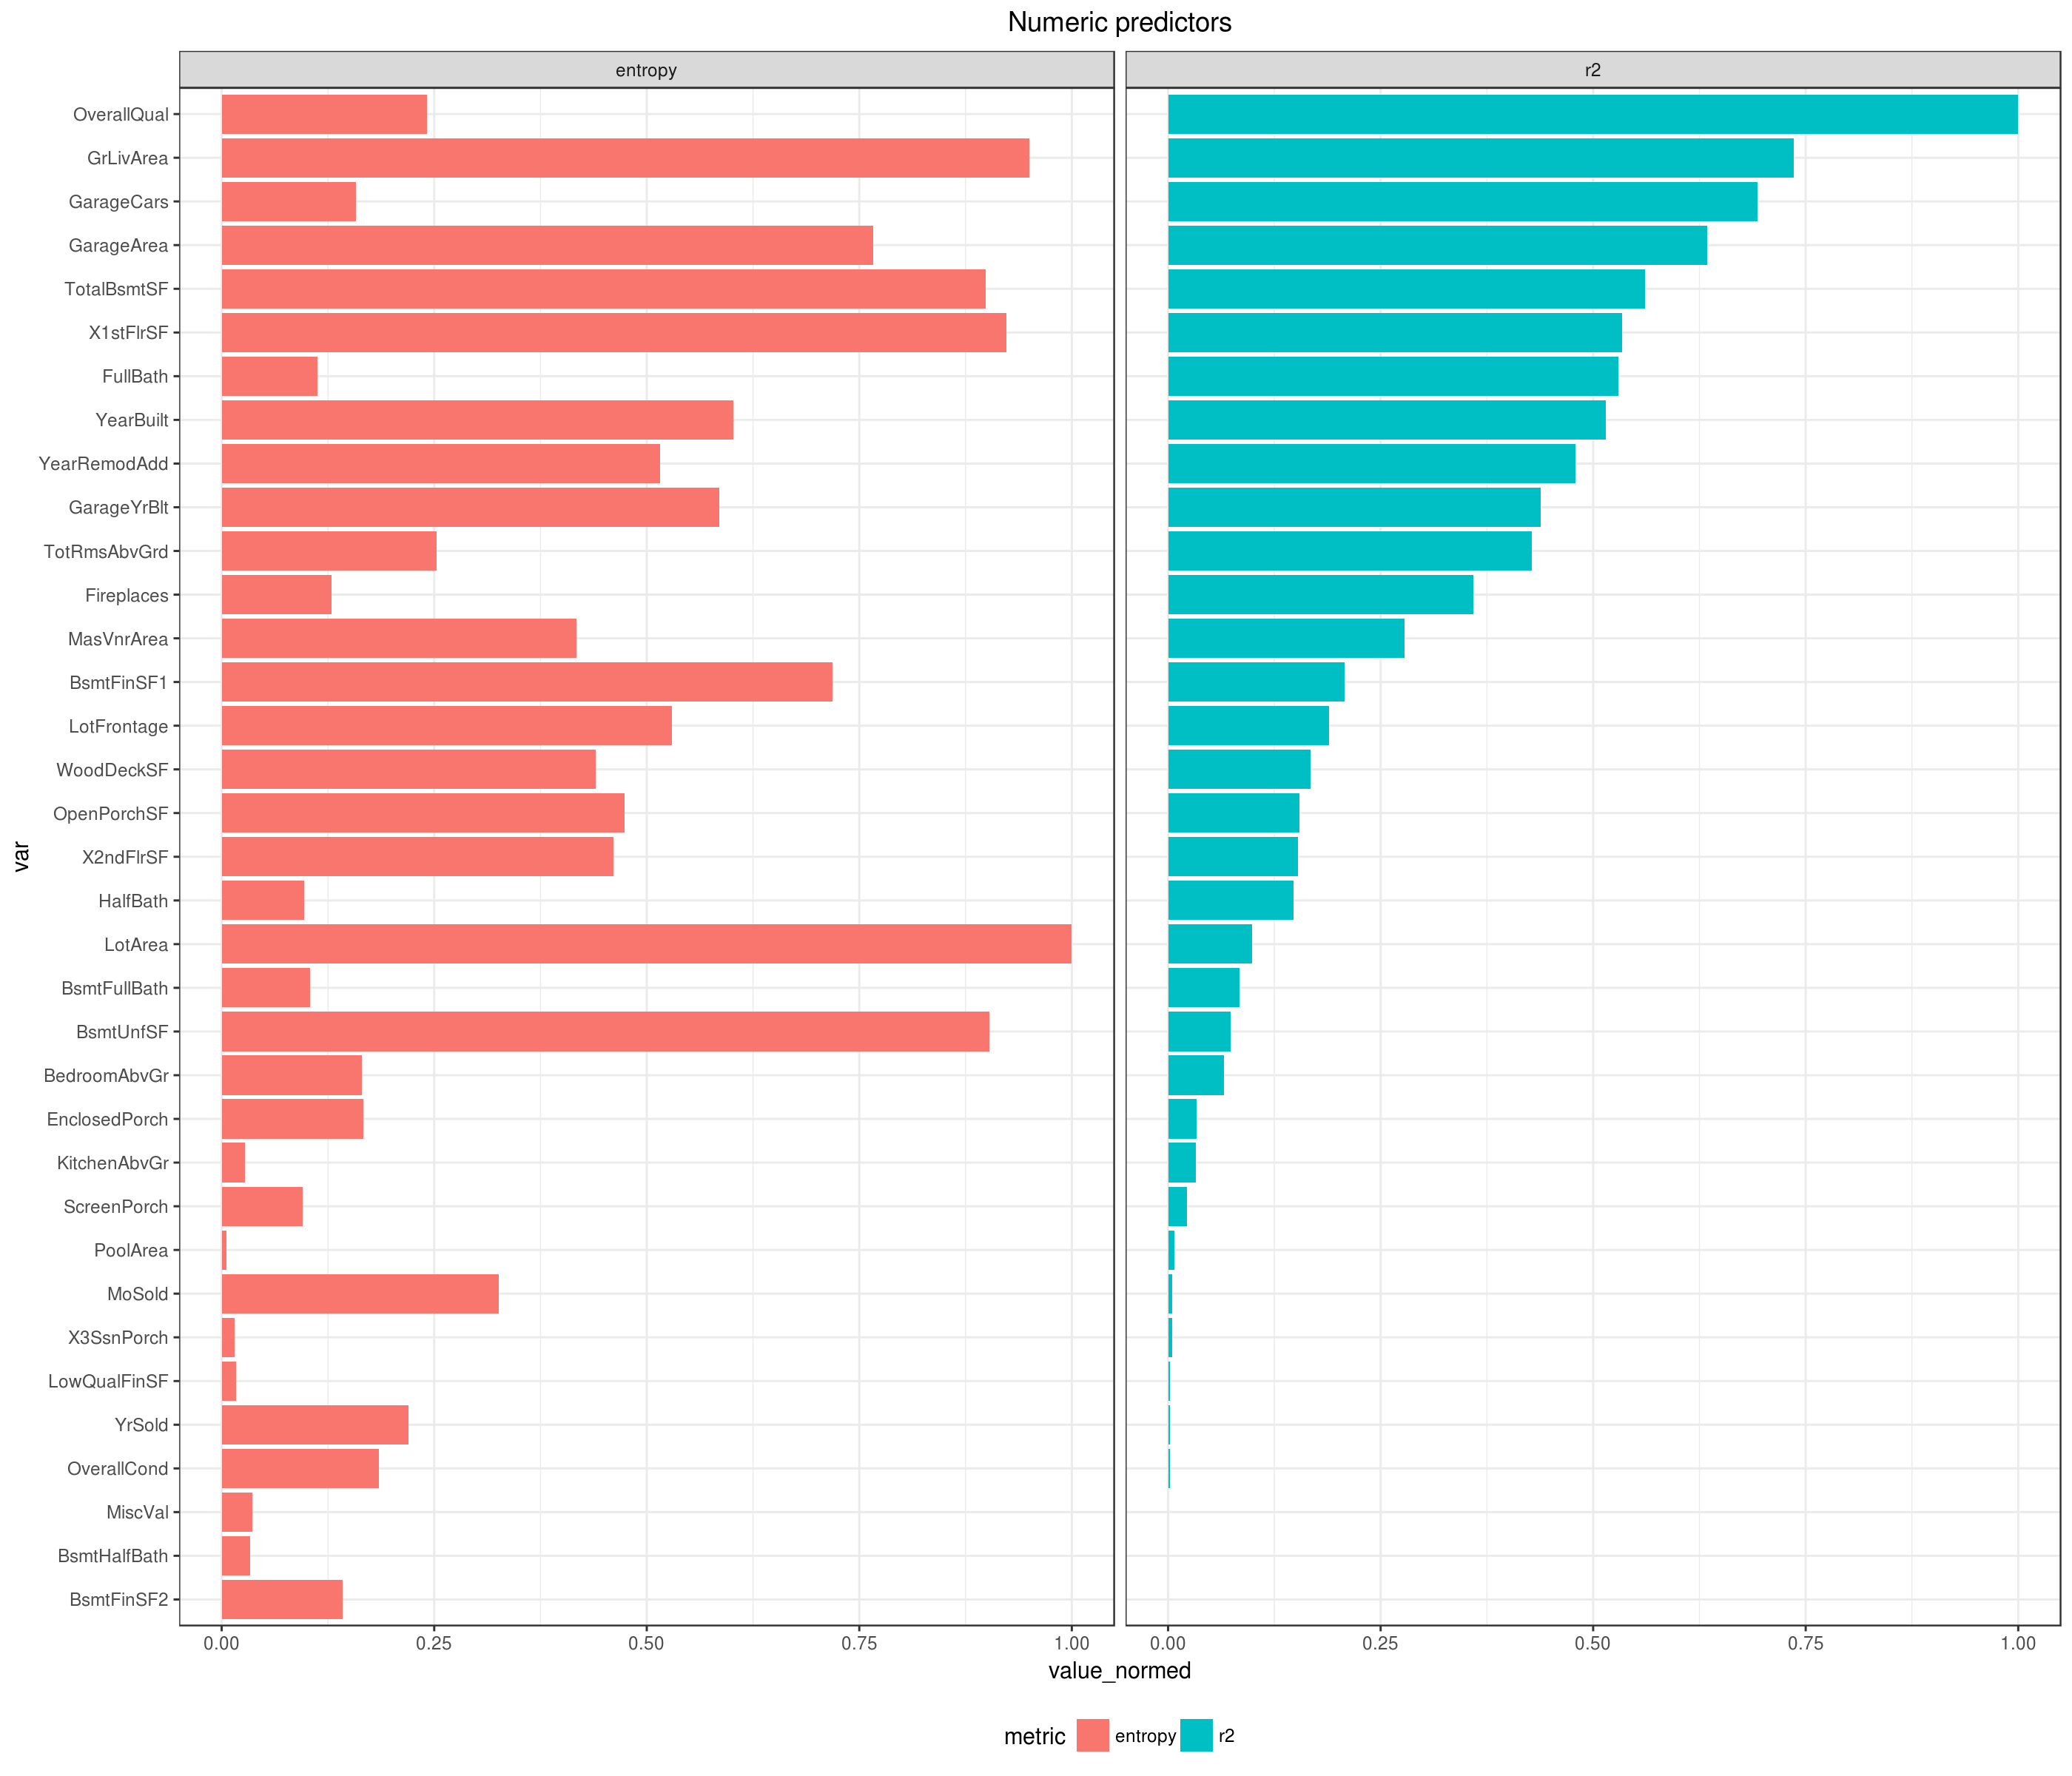

In [14]:
df_num <-
    df %>% 
    filter(type == "Numeric") %>%
    select(-type, -value) %>%
    spread(metric, value_normed)

df_num <-
    df_num %>%
    mutate(
        var = factor(var, levels = df_num %>% select(var, r2) %>% arrange(r2) %>% `[[`(1))
    ) %>%
    gather(metric, value_normed, -var)

`@@@`(14, 12, 200)
df_num %>%
ggplot(aes(x=var, y=value_normed, fill=metric)) +
geom_bar(stat="identity") +
coord_flip() +
facet_wrap(~metric, nrow = 1) +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
labs(title = "Numeric predictors")

# Treemap of categorical predictors

ggplot2 plugin treemapify(which btw looks very pretty) is saddly buggy, thus another tree map library is used.

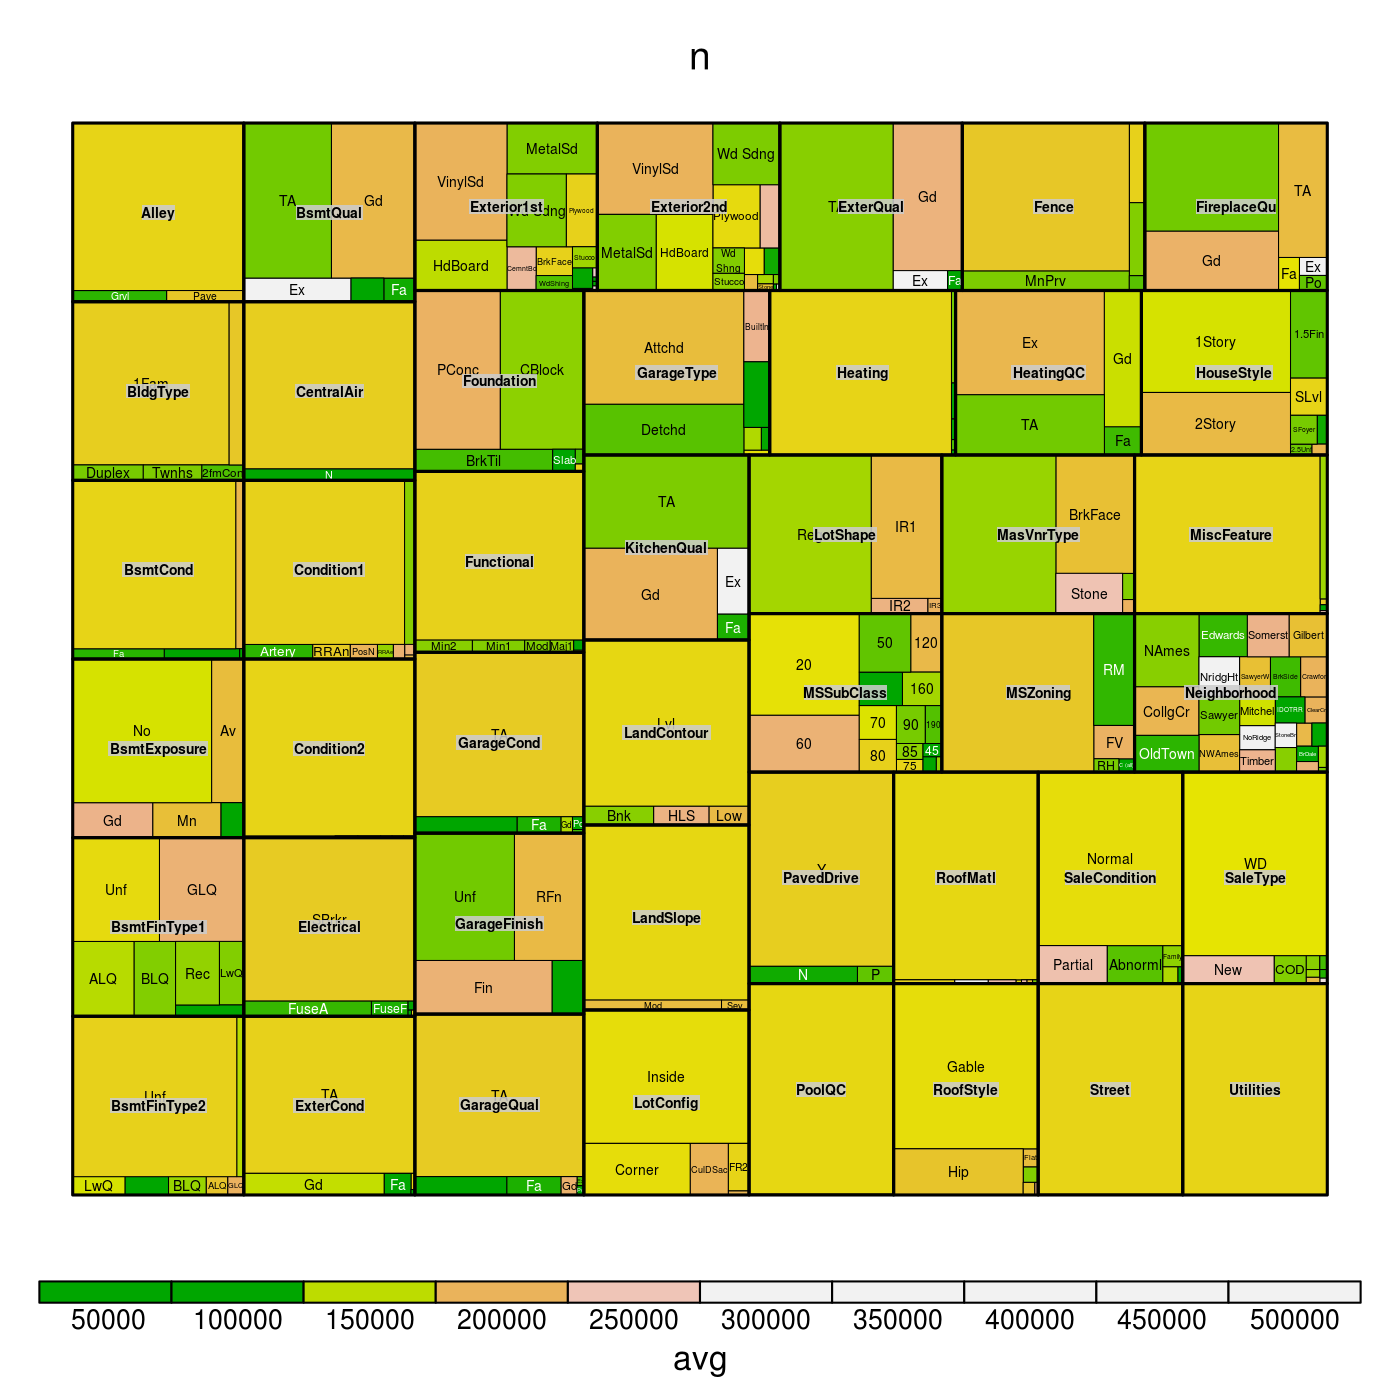

In [15]:
library(treemap, warn.conflicts=FALSE, quietly=TRUE)

df_for_treemap <-
    combinedData %>%
    filter(!is.na(SalePrice)) %>%
    select(house_prices$helpers$get_character_colnames(combinedData), SalePrice) %>%
    gather(var, value, -SalePrice) %>%
    group_by(var, value) %>%
    summarise(
        avg = median(SalePrice),
        n = n()
    )

price <- 
    combinedData %>%
    filter(!is.na(SalePrice)) %>%
    select(SalePrice) %>%
    `[[`(1)

`@@@`(7, 7, 200)
treemap(df_for_treemap,
       index=c("var", "value"),
       vSize="n",
       vColor="avg",
       type="value",
       palette=terrain.colors(10),
       mapping=quantile(price, c(0.1, 0.5, 0.9)),
       fontsize.labels = 5,
       border.lwds = c(1.5, 0.5))

# Scatterplots of numerical predictors
## $log(SalePrice) \sim log(predictor + 1)$

In [16]:
df_for_ggplot <-
    combinedData %>%
    filter(!is.na(SalePrice)) %>%
    select_if(is.numeric) %>%
    mutate(
        price_log = log(SalePrice)
    ) %>%
    select(-SalePrice, -Id) %>%
    gather(var, value, -price_log) %>%
    replace_na(list(value = 0)) %>%
    mutate(
        value = log(value + 1),
        weak = var %in% attr_sel$useless_numeric_vars
    )

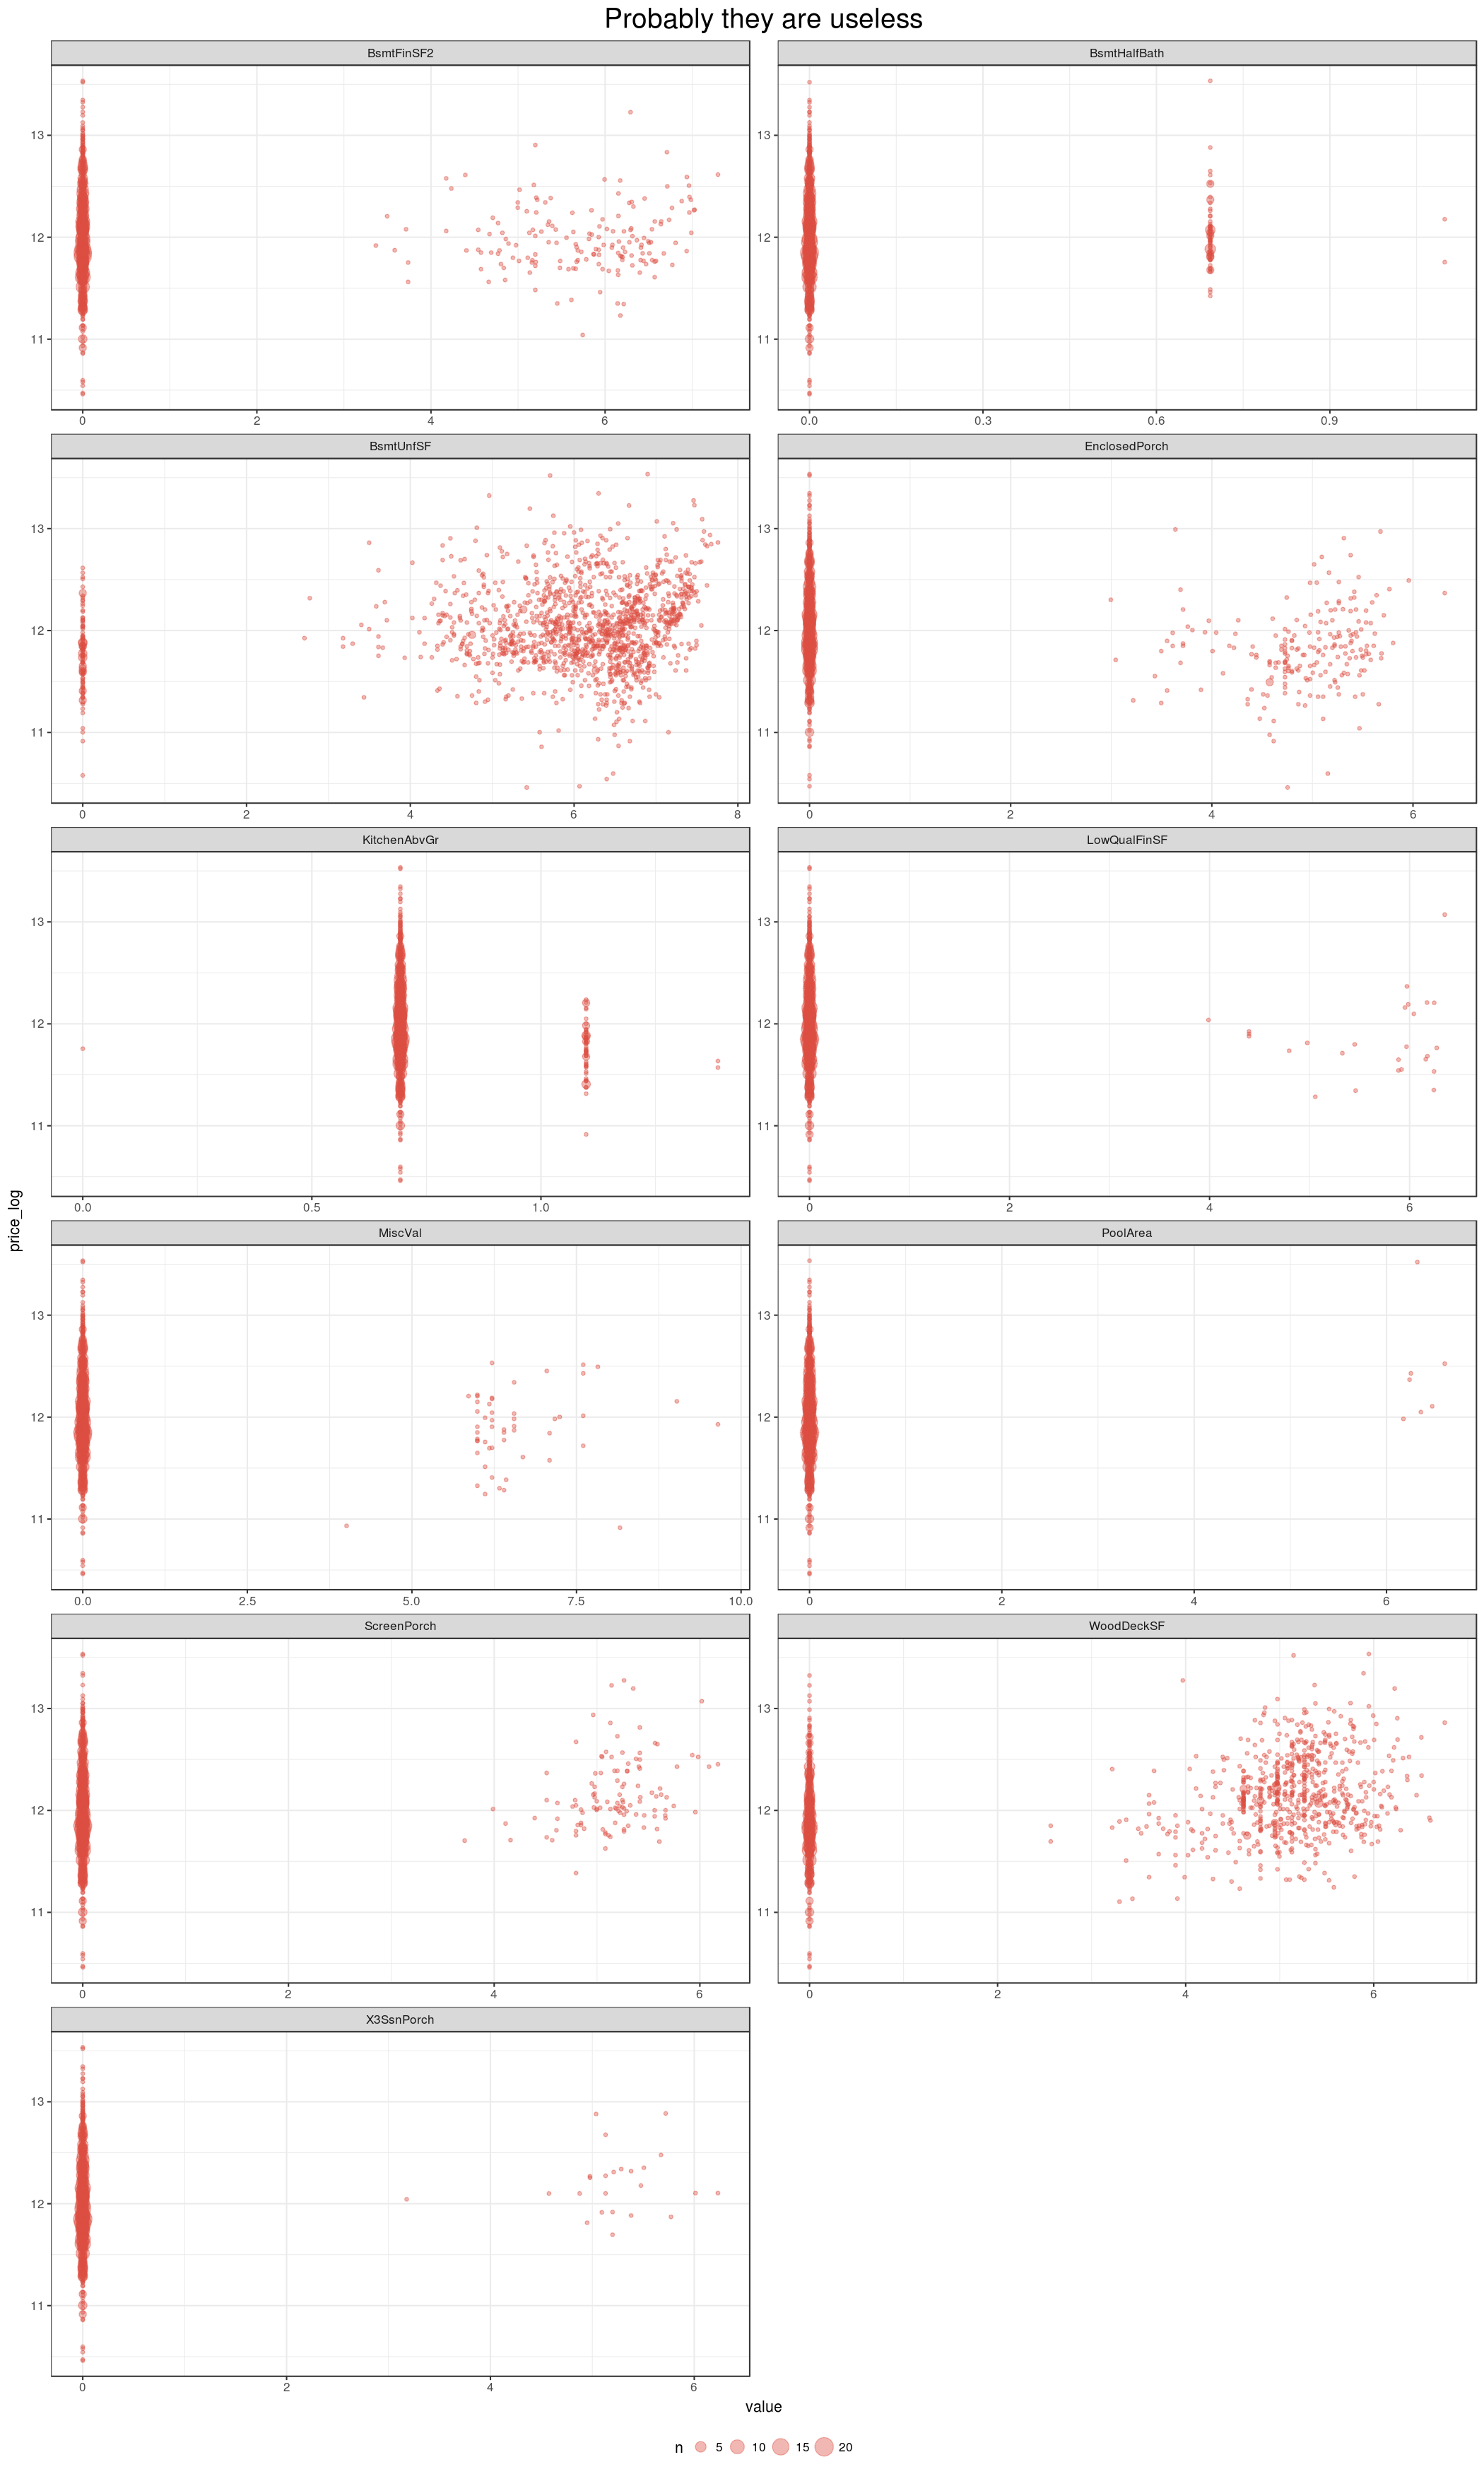

In [17]:
`@@@`(15, 25, 140)
df_for_ggplot %>%
filter(weak) %>%
ggplot(aes(value, price_log)) +
geom_count(alpha = 0.4, color='#dc4e41') +
facet_wrap(~var, ncol = 2, scale='free') +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5, size=20)) +
labs(title = "Probably they are useless")

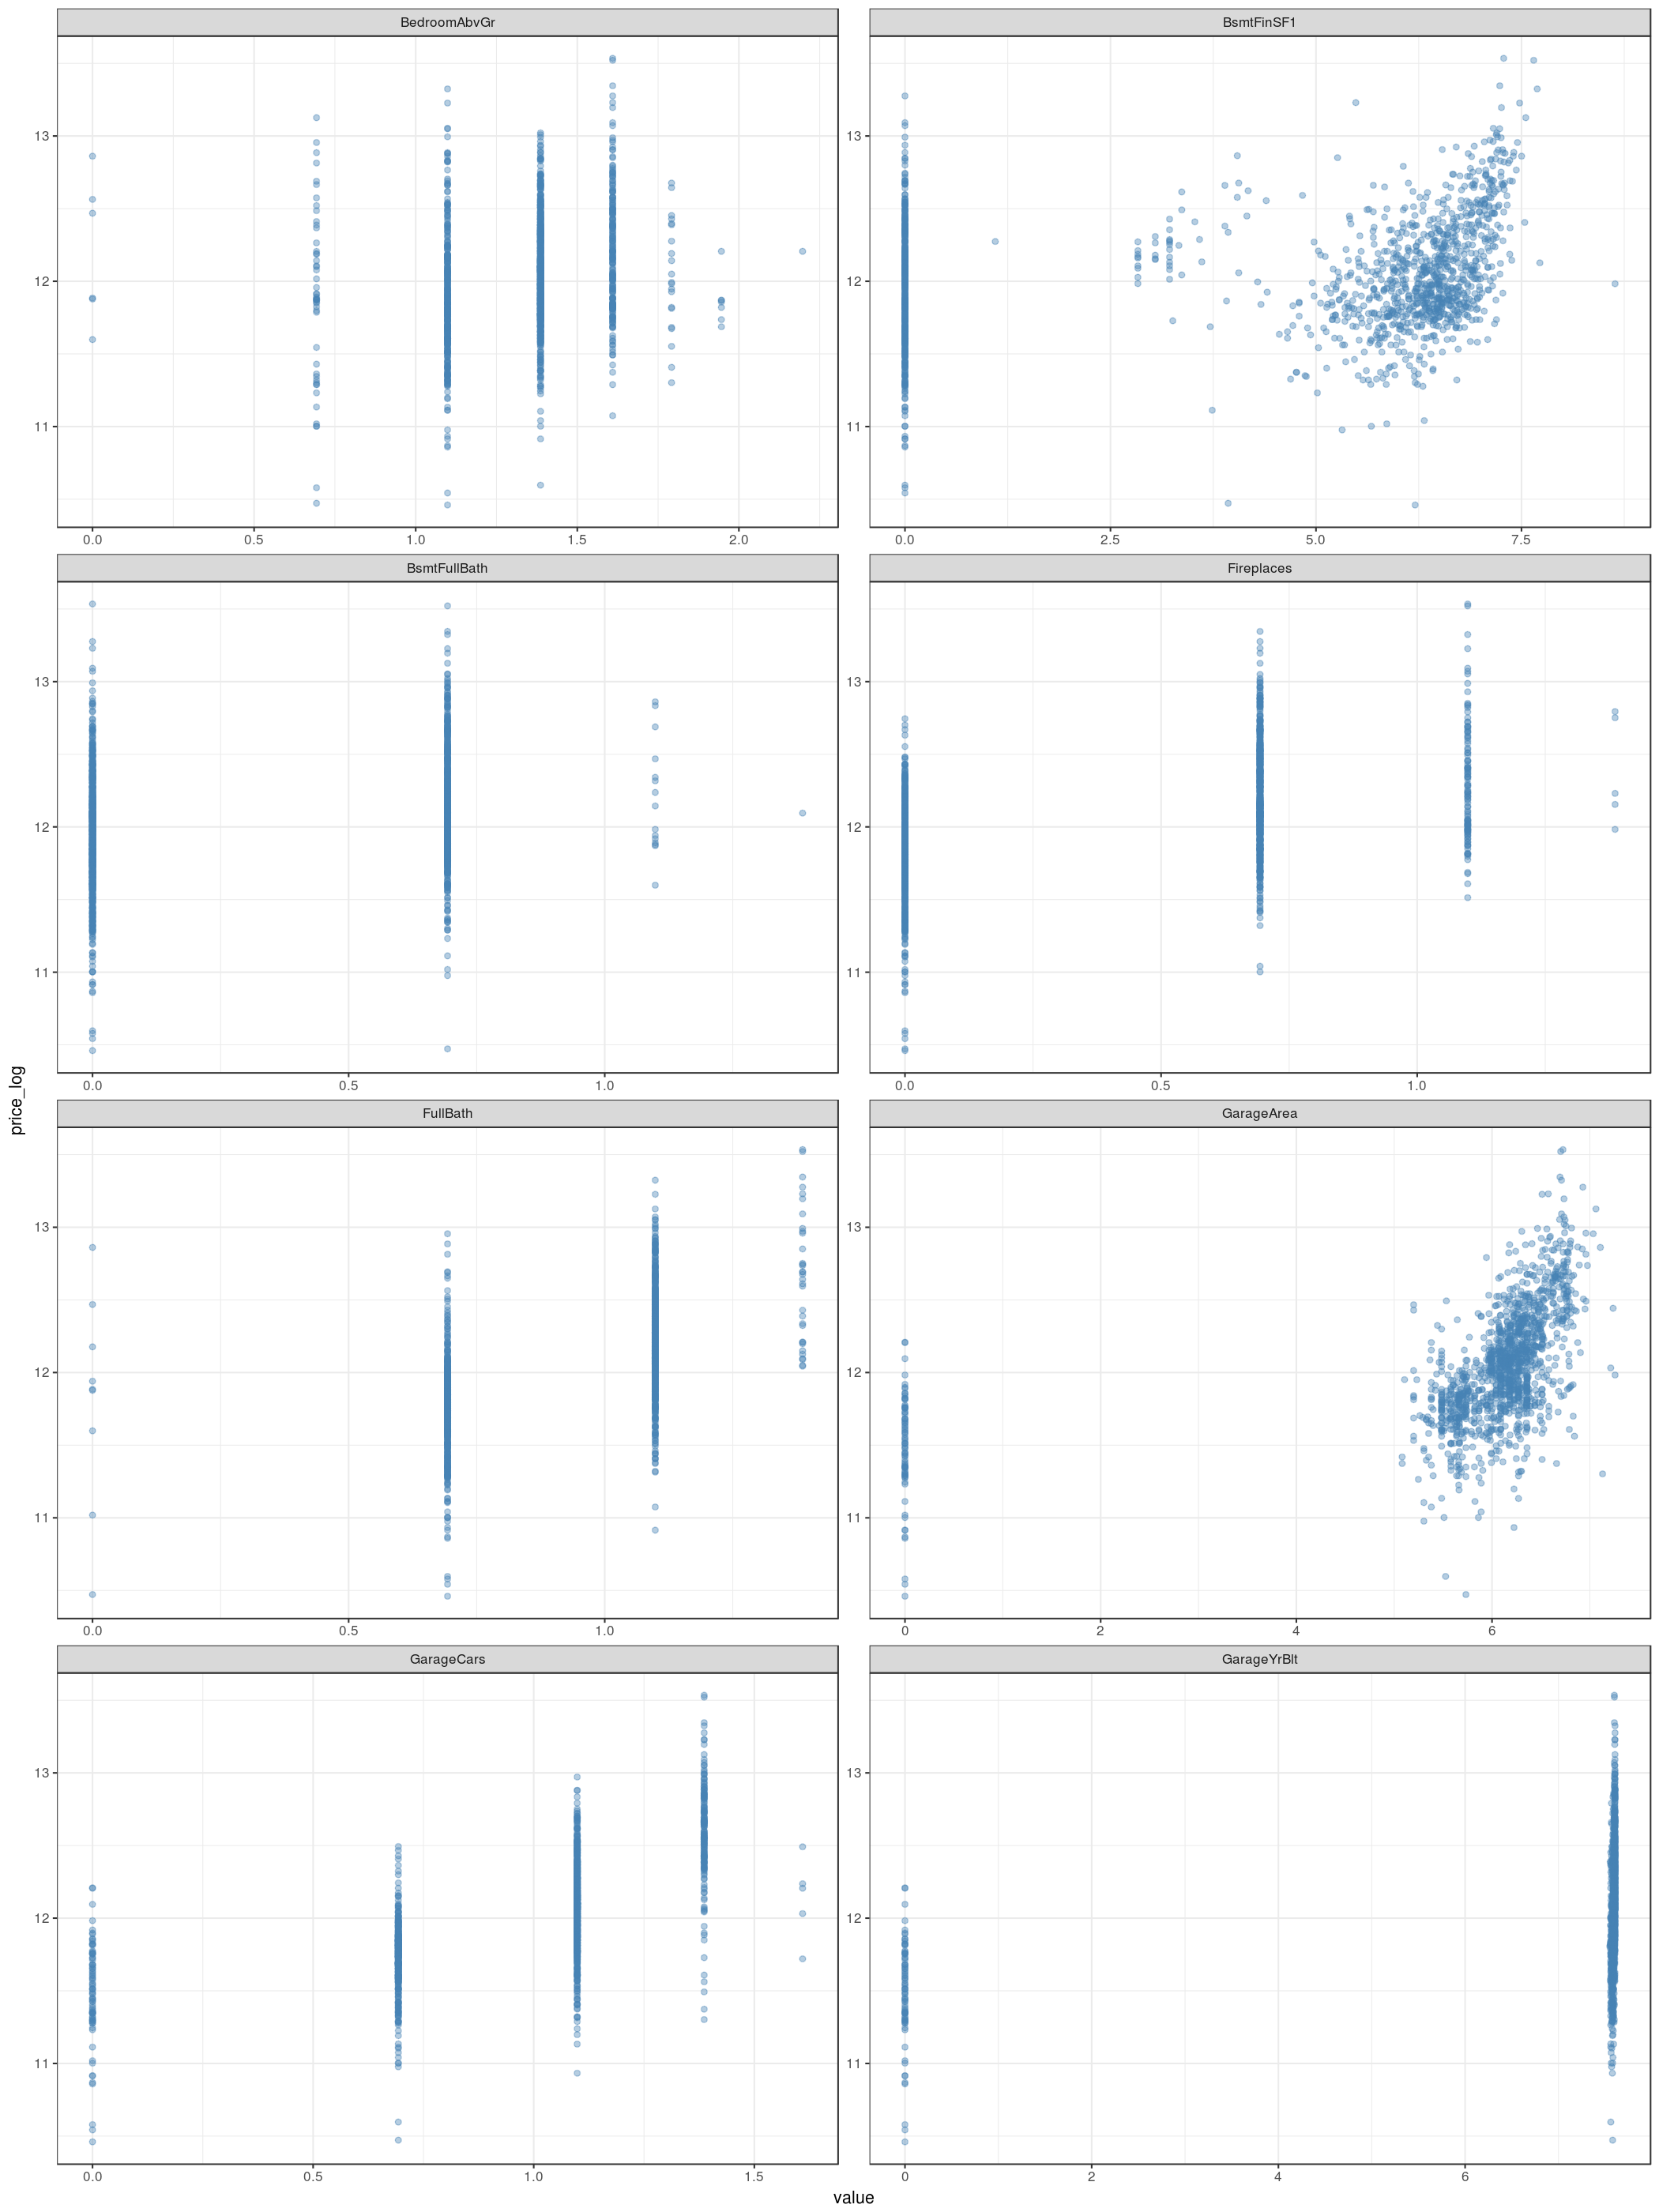

In [18]:
`@@@`(15, 20, 140)
df_for_ggplot %>%
filter(!weak) %>%
mutate(
    group_no = group_indices(., var)
) %>% 
filter(group_no < 9) %>%
ggplot(aes(value, price_log)) +
geom_point(alpha = 0.4, color='steelblue') +
facet_wrap(~var, ncol = 2, scale='free') +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5))

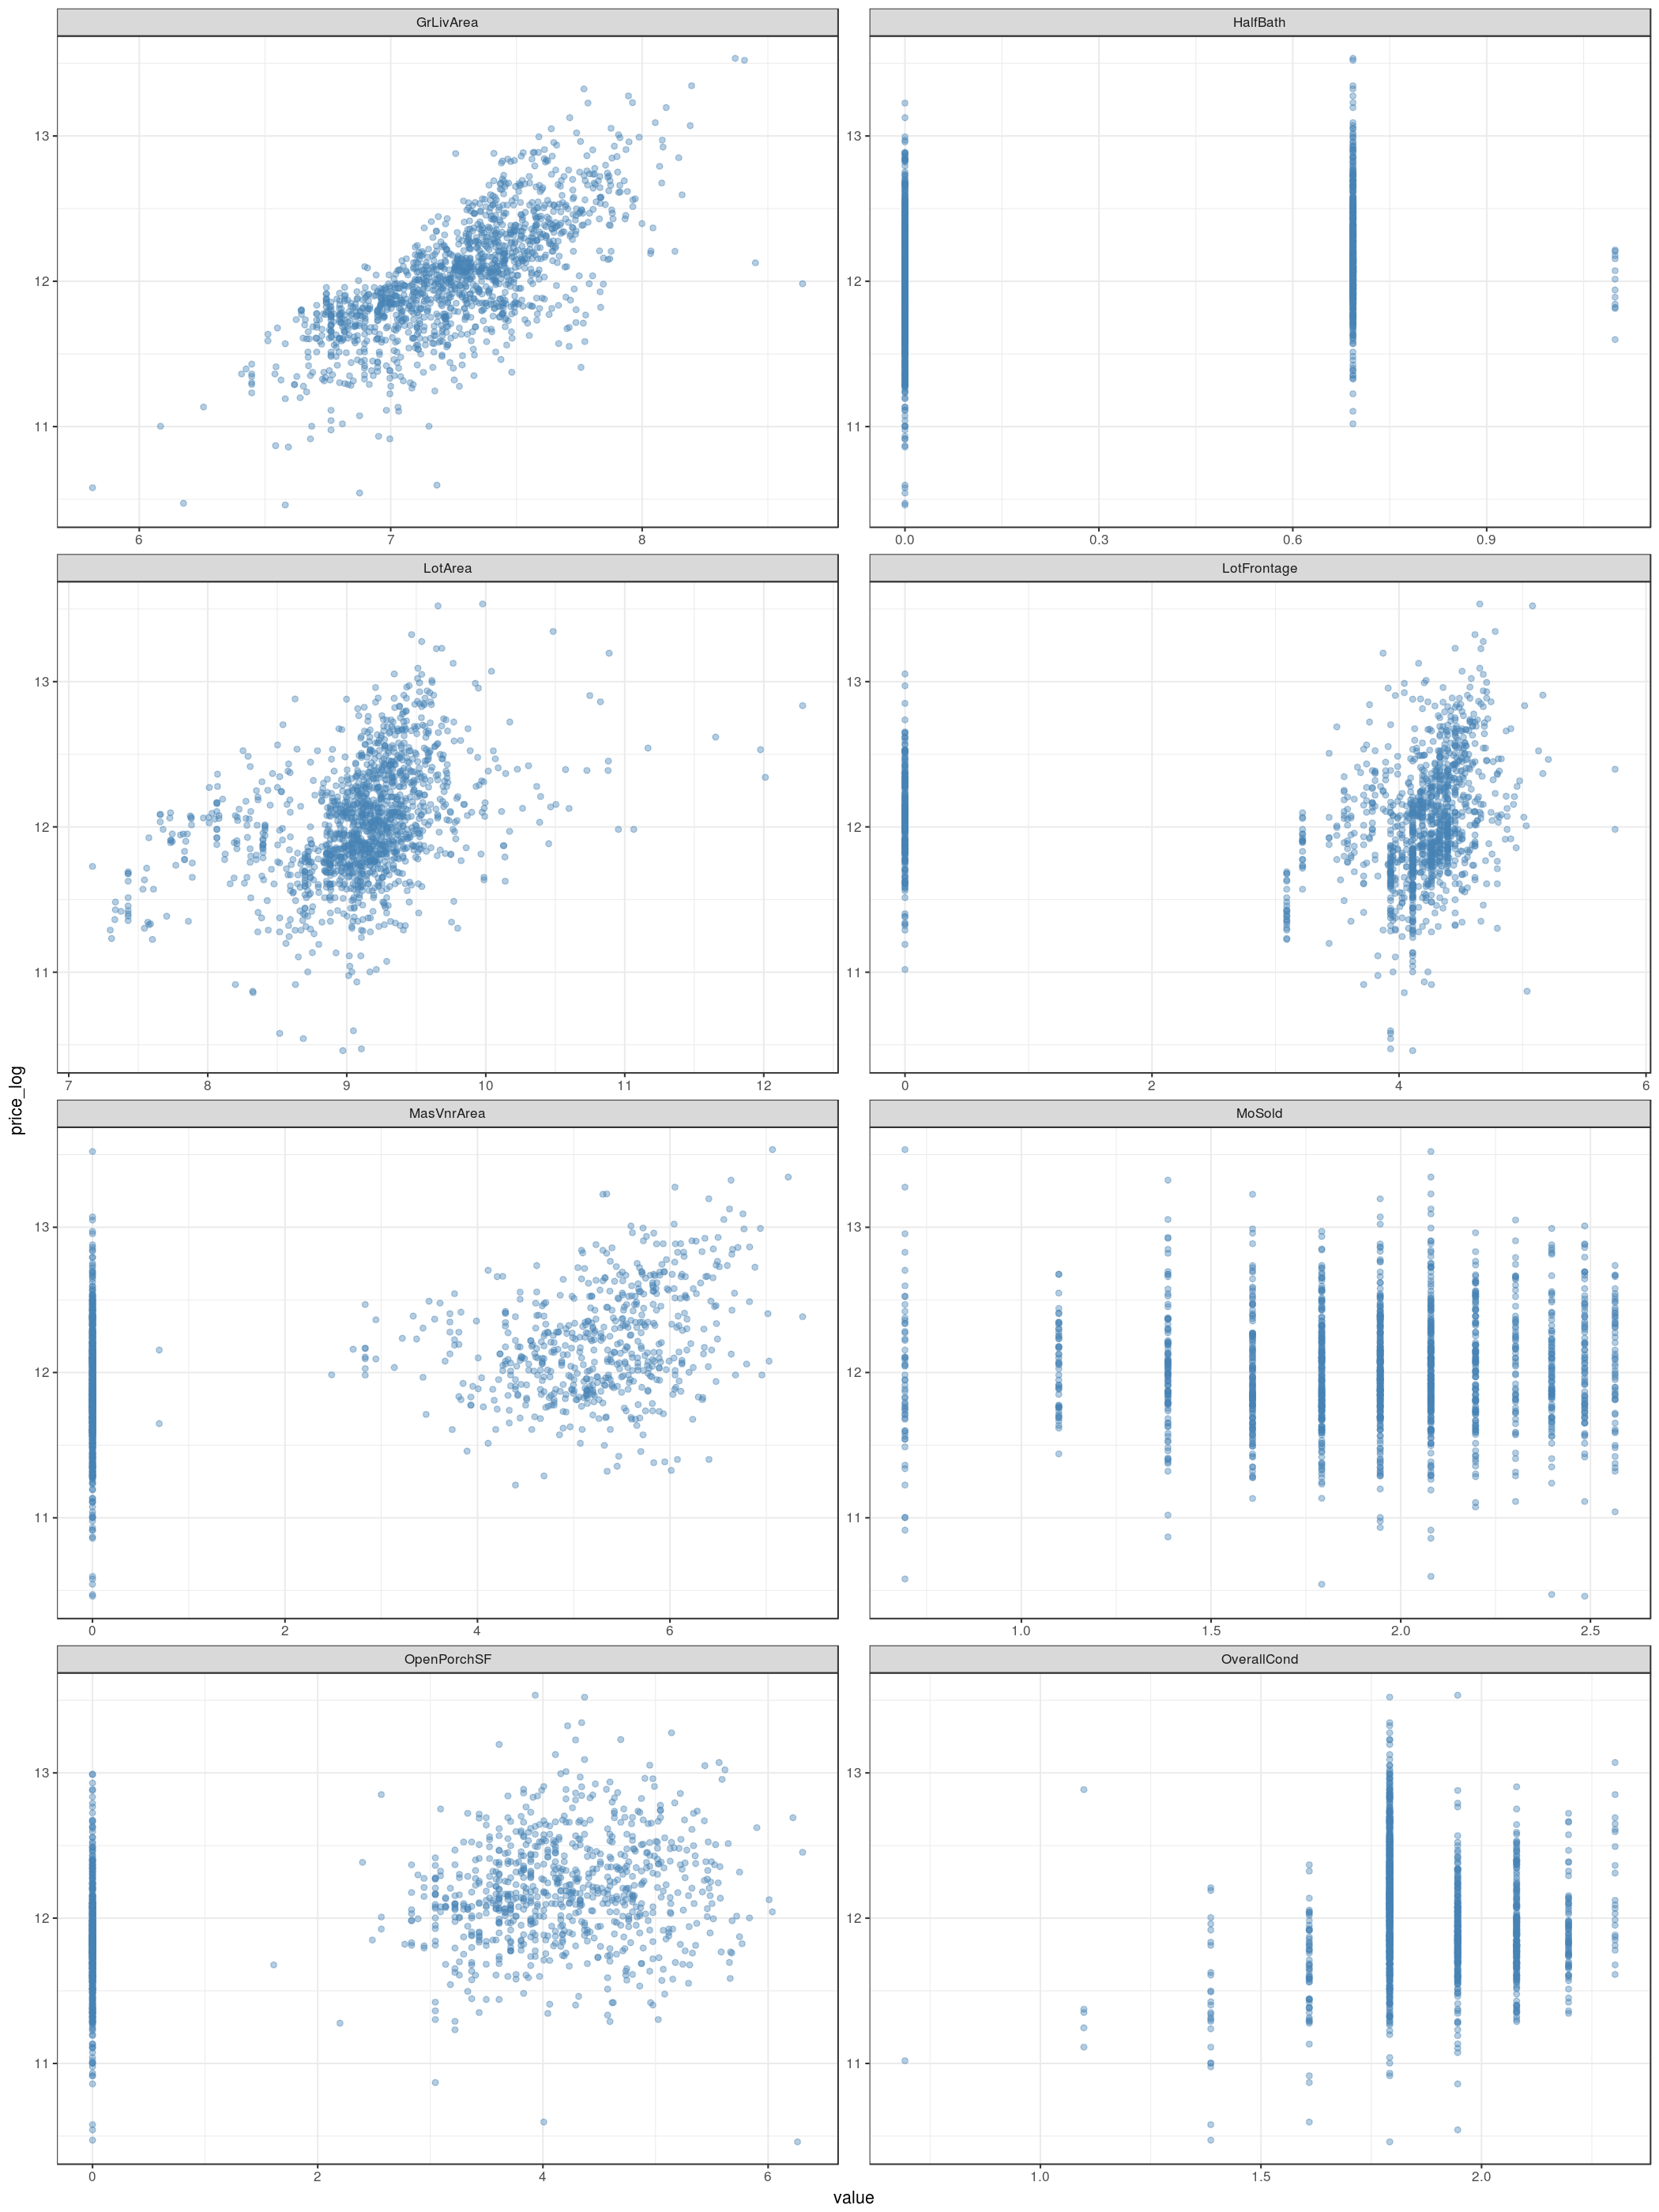

In [19]:
`@@@`(15, 20, 140)
df_for_ggplot %>%
filter(!weak) %>%
mutate(
    group_no = group_indices(., var)
) %>% 
filter(group_no >= 9, group_no < 17) %>%
ggplot(aes(value, price_log)) +
geom_point(alpha = 0.4, color='steelblue') +
facet_wrap(~var, ncol = 2, scale='free') +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5))

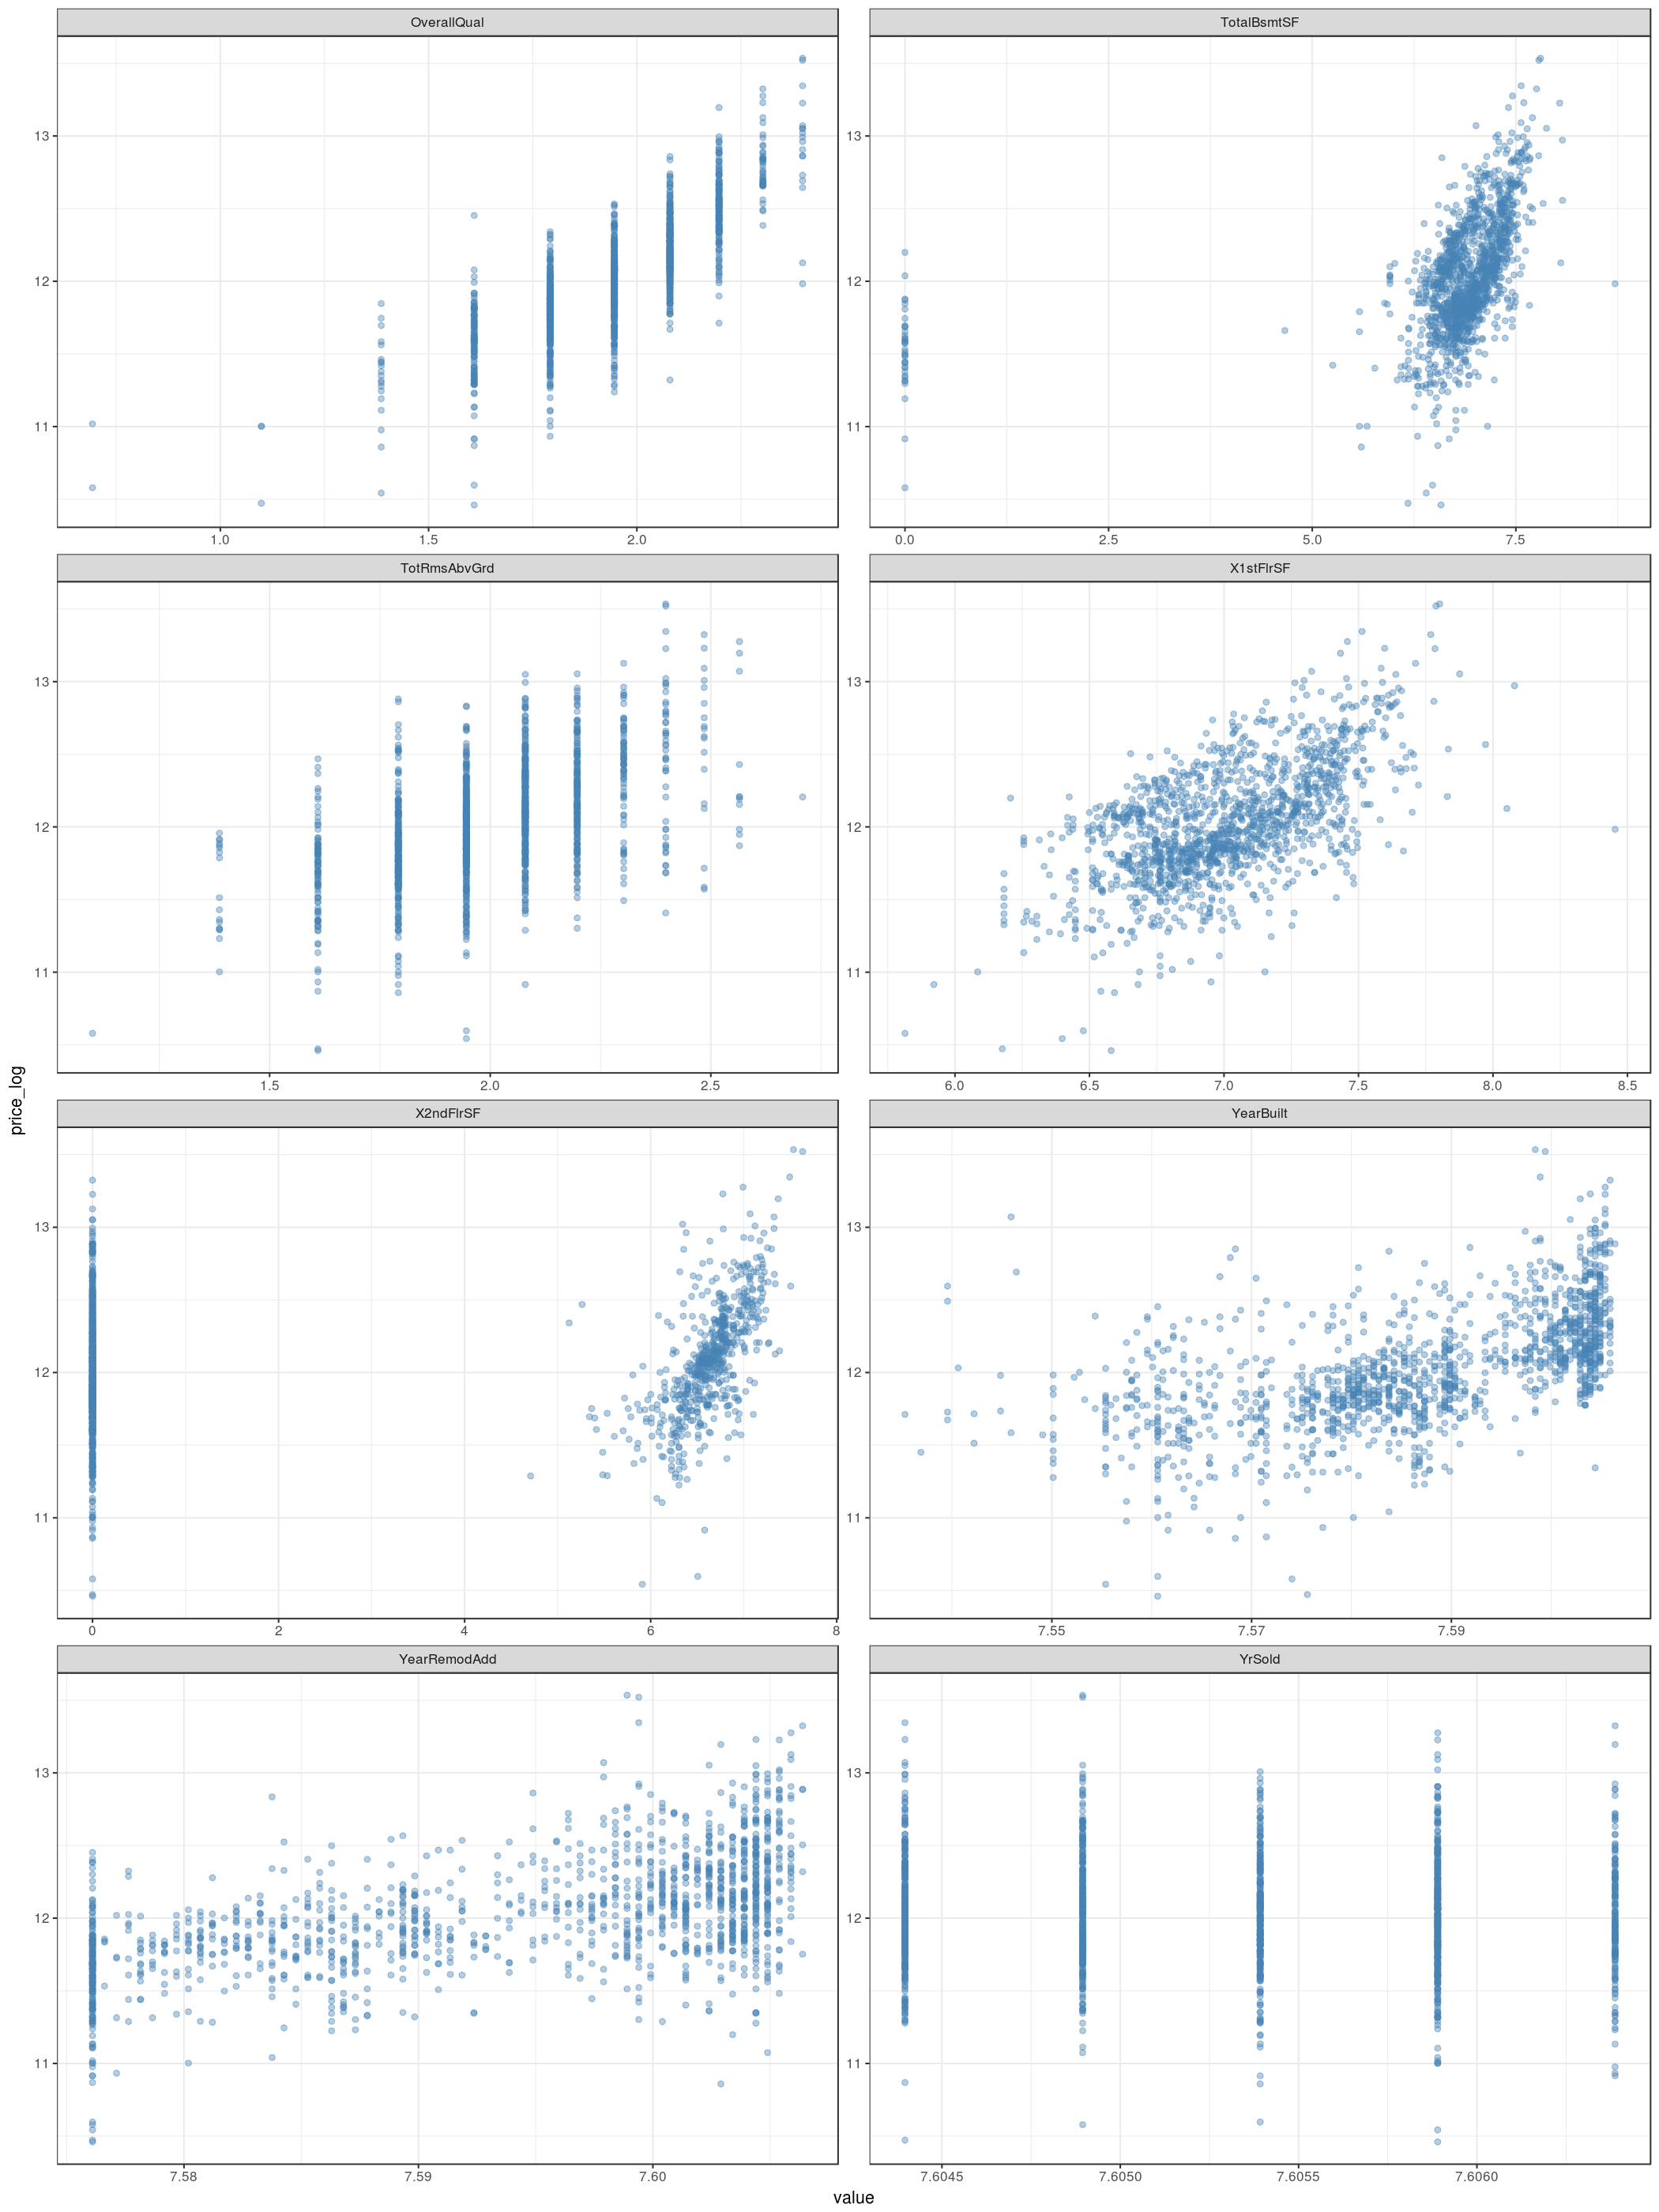

In [20]:
`@@@`(15, 20, 140)
df_for_ggplot %>%
filter(!weak) %>%
mutate(
    group_no = group_indices(., var)
) %>% 
filter(group_no >= 17) %>%
ggplot(aes(value, price_log)) +
geom_point(alpha = 0.4, color='steelblue') +
facet_wrap(~var, ncol = 2, scale='free') +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5))

Looks like `MoSold` and `YrSold` will be doing better as categorical factors